In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

from datetime import timedelta

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

# COVID-19 Time-Series Case Prediction

In this dataset, I would like to model the evolution of COVID-19 cases in the United States. I have a number of datasets from the CDC regarding cases, deaths, and vaccination rates per state, and I will do some small exploratory analyses to look at some potential relationships in order to decide on which features to add into the model. Additionally, I have a bunch of per-state metadata that I pulled from the latest (2019) census report. Unfortunately, a key piece of the puzzle (at least, in terms of predicting deaths) is the hospital utilization, but I haven't been able to find any per-county dataset with this information without scraping the state COVID-19 Dashboards. I don't know how to do that.

My features:
- Longitudinal Features:
    - Cases
    - Deaths
    - Vaccination Rates
- Other Metadata:
    - Fertility Info
    - Health Insurance Characteristics
    - Private Health Insurance
    - Income
    - Poverty Status
    - Social/Demographic Characteristics
    - Work/Economic Characteristics
 
In total, there are 352 columns of non-longitudinal features. I will likely have to cull these down further when making models of the data. Details on how this data was cleaned can be shown in the other notebook (also attached).

## Some Final Cleaning

In [30]:
data = pd.read_csv("cases_deaths_vaccinations_byState_imputed.csv", sep=',', parse_dates=["date"])
data

,state,date,cases,deaths,total_distributed,distributed_per_hundred,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,daily_vaccinations_per_million
0,Alabama,2021-01-12,3848,226,377025.0,7.69,0.1500,1.590,1205.0
1,Alabama,2021-01-13,3147,187,378975.0,7.73,0.1900,1.710,1205.0
2,Alabama,2021-01-14,3588,185,435350.0,8.88,0.2350,1.880,1445.0
3,Alabama,2021-01-15,2945,85,444650.0,9.07,0.2800,2.050,1525.0
4,Alabama,2021-01-16,3153,89,444650.0,9.07,0.2925,2.205,1529.0
...,...,...,...,...,...,...,...,...,...
12175,Wisconsin,2022-03-03,576,52,11106345.0,190.75,64.6600,169.700,846.0
12176,Wisconsin,2022-03-04,542,39,11114045.0,190.88,64.6900,169.810,999.0
12177,Wisconsin,2022-03-05,0,0,11118845.0,190.97,64.7100,169.900,824.0
12178,Wisconsin,2022-03-06,0,0,11118845.0,190.97,64.7400,169.990,835.0


In [31]:
searches = pd.read_csv("covid_searches_cleaned_imputed.csv", parse_dates=["date"])
keep_cols = [col for col in searches.columns if any(name in col for name in ["sub_region_1", "date", "symptom"])]
searches = searches[keep_cols]
newcols = ["state" if col == "sub_region_1" else col for col in searches.columns]
searches.columns = newcols
searches = searches[searches["date"] >= '2021-01-12']
searches

,state,date,symptom:pancreatitis,symptom:Hyperthyroidism,symptom:Headache,symptom:Heart arrhythmia,symptom:Heartburn,symptom:Hematochezia,symptom:Hematoma,symptom:Hematuria,...,symptom:Amenorrhea,symptom:Hydrocephalus,symptom:Nocturnal enuresis,symptom:Esophagitis,symptom:Polyuria,symptom:Upper respiratory tract infection,symptom:Granuloma,symptom:Hypocalcaemia,symptom:Asphyxia,symptom:Atheroma
11357,Alabama,2021-01-12,0.45,1.11,4.43,2.46,3.12,0.20,0.33,0.44,...,0.14,0.17,0.12,0.14,0.14,0.15,0.14,0.17,0.06,0.17
11358,Alabama,2021-01-13,0.39,1.02,4.41,2.30,3.02,0.19,0.36,0.44,...,0.13,0.18,0.11,0.17,0.14,0.19,0.15,0.14,0.09,0.11
11359,Alabama,2021-01-14,0.46,1.12,4.75,2.33,3.19,0.20,0.33,0.39,...,0.14,0.16,0.11,0.18,0.12,0.18,0.13,0.16,0.09,0.12
11360,Alabama,2021-01-15,0.38,1.02,4.40,2.17,3.08,0.21,0.35,0.36,...,0.12,0.15,0.10,0.14,0.15,0.17,0.11,0.17,0.11,0.14
11361,Alabama,2021-01-16,0.39,0.87,4.72,1.91,3.15,0.20,0.26,0.44,...,0.11,0.07,0.13,0.16,0.20,0.14,0.10,0.16,0.12,0.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25942,Wisconsin,2022-04-12,0.35,1.09,3.74,3.01,2.20,0.17,0.35,0.38,...,0.11,0.15,0.12,0.11,0.11,0.18,0.18,0.15,0.08,0.12
25943,Wisconsin,2022-04-13,0.41,1.09,3.77,2.33,2.18,0.19,0.36,0.40,...,0.12,0.13,0.12,0.13,0.15,0.19,0.18,0.15,0.10,0.14
25944,Wisconsin,2022-04-14,0.36,1.06,3.50,2.03,2.15,0.20,0.36,0.40,...,0.09,0.12,0.13,0.10,0.09,0.15,0.19,0.20,0.09,0.14
25945,Wisconsin,2022-04-15,0.36,1.03,3.52,1.96,2.23,0.18,0.34,0.40,...,0.12,0.11,0.13,0.14,0.09,0.15,0.18,0.15,0.10,0.13


In [32]:
search_states = searches.state.unique()
cases_states = data.state.unique()

common_states = [state for state in search_states if state in cases_states]
len(common_states)

29

In [33]:
# keeping the states that are in common in both dataframes:

data = data[data['state'].isin(common_states)]
searches = searches[searches['state'].isin(common_states)]

I quickly want to make a new dataframe and test if any symptoms have correlations with the number of cases.

Text(0, 0.5, 'Observation')

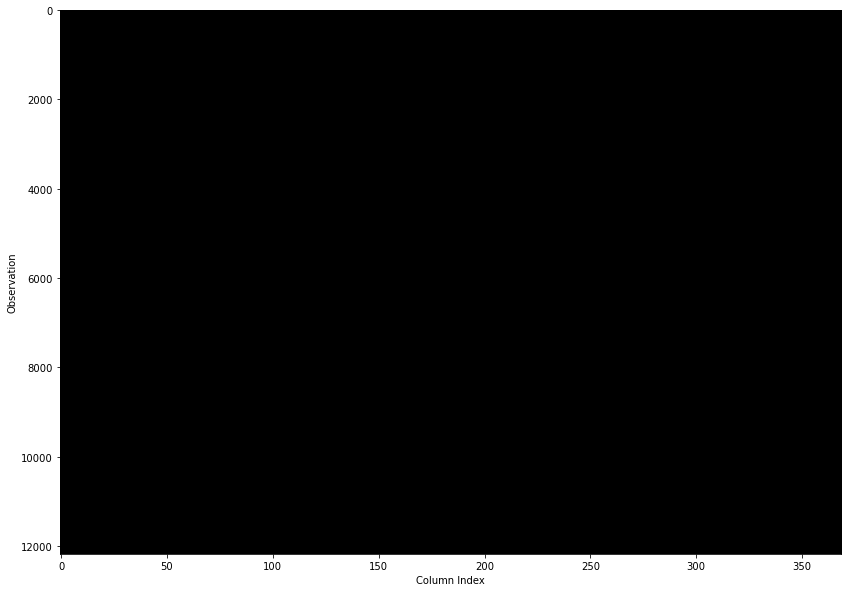

In [34]:
test_df = data.merge(searches, on=['state', 'date'], how='left')

fig, ax = plt.subplots(figsize=(14,10))
ax.imshow(test_df.isna(), aspect="auto", interpolation="nearest", cmap="gray")

ax.set_xlabel("Column Index")
ax.set_ylabel("Observation")

In [35]:
correlation = test_df.corr()
diag_mask = np.triu(np.ones_like(correlation, dtype=bool))
colors = sns.diverging_palette(230, 20, as_cmap=True)

<AxesSubplot:>

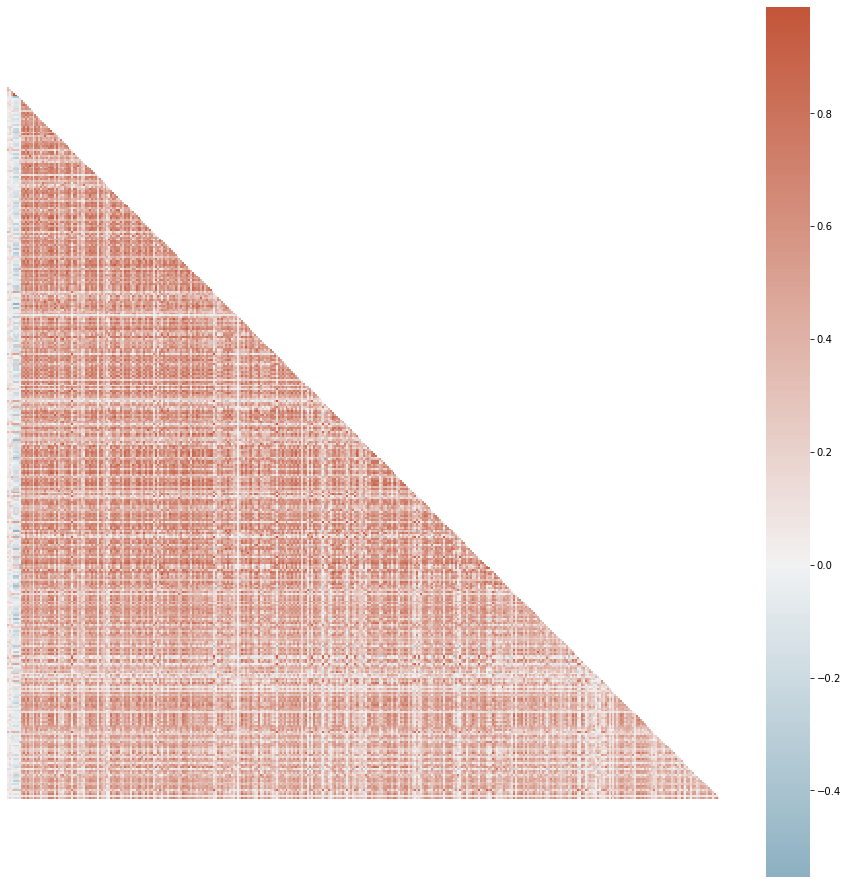

In [36]:
colors = sns.diverging_palette(230, 20, as_cmap=True)
plt.subplots(figsize=(16,16))
sns.heatmap(correlation, mask=diag_mask, center=0, square=True, cmap=colors,
           xticklabels = False, yticklabels = False)

Well, it's certainly true that the search data is highly correlated with itself. However, the correlations on the first four columns (i.e. with cases, deaths, and vaccinations) is nearly impossible to read. Let's take a closer look at it...

(As an aside, we would not expect any symptoms to be *negatively* correlated with case rates, so we are only interested in positive correlations).

In [37]:
correlation[correlation['cases'] > 0.10]['cases'].sort_values()

symptom:Stroke             0.100231
symptom:Eye strain         0.101608
symptom:Indigestion        0.102154
symptom:Tenderness         0.102551
symptom:Angioedema         0.103821
                             ...   
symptom:Chills             0.390512
total_distributed          0.397496
symptom:Fever              0.401799
symptom:Low-grade fever    0.417697
cases                      1.000000
Name: cases, Length: 76, dtype: float64

In [38]:
# I'm going to make a list of features which correlate with the number of cases by more than 0.1. I will
# keep these columns for the later analysis.

keep_cols = list(correlation[correlation['cases'] > 0.10]['cases'].sort_values().index)
keep_cols.append("state")
keep_cols.append('date')
len(keep_cols)

78

In [39]:
test_df_cut = test_df[keep_cols]
test_df_cut = test_df_cut.set_index(['state', 'date', "cases"]).reset_index()
test_df_cut

,state,date,cases,symptom:Stroke,symptom:Eye strain,symptom:Indigestion,symptom:Tenderness,symptom:Angioedema,symptom:Pleurisy,symptom:Middle back pain,...,symptom:Common cold,symptom:Phlegm,symptom:Pneumonia,symptom:Shivering,symptom:Sputum,symptom:Hypoxemia,symptom:Chills,total_distributed,symptom:Fever,symptom:Low-grade fever
0,Alabama,2021-01-12,3848,2.60,0.29,1.52,0.11,0.18,0.20,0.38,...,9.75,0.63,1.67,0.26,0.20,0.70,0.31,377025.0,3.88,0.28
1,Alabama,2021-01-13,3147,2.71,0.26,1.57,0.15,0.18,0.25,0.37,...,9.62,0.57,1.56,0.23,0.17,0.73,0.34,378975.0,3.92,0.27
2,Alabama,2021-01-14,3588,2.64,0.31,1.66,0.15,0.18,0.21,0.41,...,9.36,0.59,1.63,0.21,0.15,0.76,0.31,435350.0,4.06,0.28
3,Alabama,2021-01-15,2945,2.52,0.27,1.55,0.16,0.15,0.19,0.36,...,9.17,0.64,1.59,0.21,0.16,0.71,0.30,444650.0,3.81,0.27
4,Alabama,2021-01-16,3153,2.30,0.27,1.67,0.14,0.24,0.20,0.38,...,9.73,0.65,1.28,0.26,0.14,0.73,0.30,444650.0,3.78,0.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12175,Wisconsin,2022-03-03,576,2.69,0.23,1.30,0.15,0.23,0.10,0.27,...,8.38,0.63,1.05,0.19,0.17,0.24,0.25,11106345.0,2.89,0.14
12176,Wisconsin,2022-03-04,542,2.46,0.20,1.28,0.11,0.20,0.11,0.26,...,7.90,0.55,0.94,0.17,0.15,0.25,0.24,11114045.0,2.80,0.09
12177,Wisconsin,2022-03-05,0,2.06,0.17,1.49,0.12,0.18,0.11,0.29,...,8.50,0.63,0.85,0.18,0.12,0.24,0.22,11118845.0,2.93,0.15
12178,Wisconsin,2022-03-06,0,2.09,0.16,1.58,0.13,0.18,0.11,0.25,...,8.73,0.66,0.93,0.20,0.15,0.25,0.26,11118845.0,2.98,0.13


In [59]:
test_df_cut.to_csv("COVID19_cases_searches_naiveLR.csv", index=False)

## An Easy Model: do google search patterns alone linearly correlate with case rates?

While my goal is to ***predict*** case rates, a strong multiple linear regression may help us determine which features are useful to keep for the time series modeling. Right now, we have too many features to observations, so I would like to cull the number of features to those which appear most relevant. Unfortunately, we cannot do LDA since our dependent variables are not categorical (and not easily separable into categorical states without quantitatively defining a "COVID-wave"), so I will have to rely on this ad-hoc feature selection.

### Fitting to a Naive Linear Model

I will use a simple multiple linear model to determine how well our selected google search trends can predict the number of cases. This will help us determine whether our features are useful at all, and give us a base error metric to compare our later models against.

In [60]:
test_df_cut = pd.read_csv("COVID19_cases_searches_naiveLR.csv")
test_df_cut.head()

,state,date,cases,symptom:Stroke,symptom:Eye strain,symptom:Indigestion,symptom:Tenderness,symptom:Angioedema,symptom:Pleurisy,symptom:Middle back pain,...,symptom:Common cold,symptom:Phlegm,symptom:Pneumonia,symptom:Shivering,symptom:Sputum,symptom:Hypoxemia,symptom:Chills,total_distributed,symptom:Fever,symptom:Low-grade fever
0,Alabama,2021-01-12,3848,2.60,0.29,1.52,0.11,0.18,0.20,0.38,...,9.75,0.63,1.67,0.26,0.20,0.70,0.31,377025.0,3.88,0.28
1,Alabama,2021-01-13,3147,2.71,0.26,1.57,0.15,0.18,0.25,0.37,...,9.62,0.57,1.56,0.23,0.17,0.73,0.34,378975.0,3.92,0.27
2,Alabama,2021-01-14,3588,2.64,0.31,1.66,0.15,0.18,0.21,0.41,...,9.36,0.59,1.63,0.21,0.15,0.76,0.31,435350.0,4.06,0.28
3,Alabama,2021-01-15,2945,2.52,0.27,1.55,0.16,0.15,0.19,0.36,...,9.17,0.64,1.59,0.21,0.16,0.71,0.30,444650.0,3.81,0.27
4,Alabama,2021-01-16,3153,2.30,0.27,1.67,0.14,0.24,0.20,0.38,...,9.73,0.65,1.28,0.26,0.14,0.73,0.30,444650.0,3.78,0.26


In [42]:
test_df_cut2 = test_df_cut.drop(["state", "date"], axis=1)

#### A Few Helper Functions

In [188]:
def graph_true_vs_predict(y_val, y_pred):
    fig, ax = plt.subplots(figsize=(12,12))

    x = np.linspace(y_val.min(), y_val.max(), 2)
    y = x

    ax.scatter(y_val, y_pred, alpha = 0.3)
    ax.plot(x, y, '-r')
    
    ax.set_xlabel("True Values")
    ax.set_ylabel("Predicted Values")
    
    return fig, ax

def R2_val(y_val, y_pred):
    y_var = (y_val - y_val.mean()) ** 2
    TSS = y_var.sum()
    
    y_res = (y_val - y_pred) ** 2 
    RSS = y_res.sum()
    
    R2 = 1 - (RSS/TSS)
    
    return R2

def RMSE_val(y_val, y_pred):
    RSS = ((y_val - y_pred) ** 2).sum()
    var = RSS / y_val.shape[0]
    RMSE = var ** (1/2)
    
    return RMSE

#### Fitting the Model:

In [53]:
X_train, X_val, y_train, y_val = train_test_split(test_df_cut2.drop("cases", axis=1),
                                                  test_df_cut2["cases"],
                                                  test_size=0.2,
                                                  random_state=1)

mlr = LinearRegression()
mlr.fit(X_train, y_train)

LinearRegression()

In [49]:
y_val_pred = mlr.predict(X_val)

In [54]:
RMSE, R2 = RMSE_val(y_val, y_val_pred), R2_val(y_val, y_val_pred)
f"RMSE: {RMSE}; R2: {R2}"

'RMSE: 6391.959166935939; R2: 0.4153539353762593'

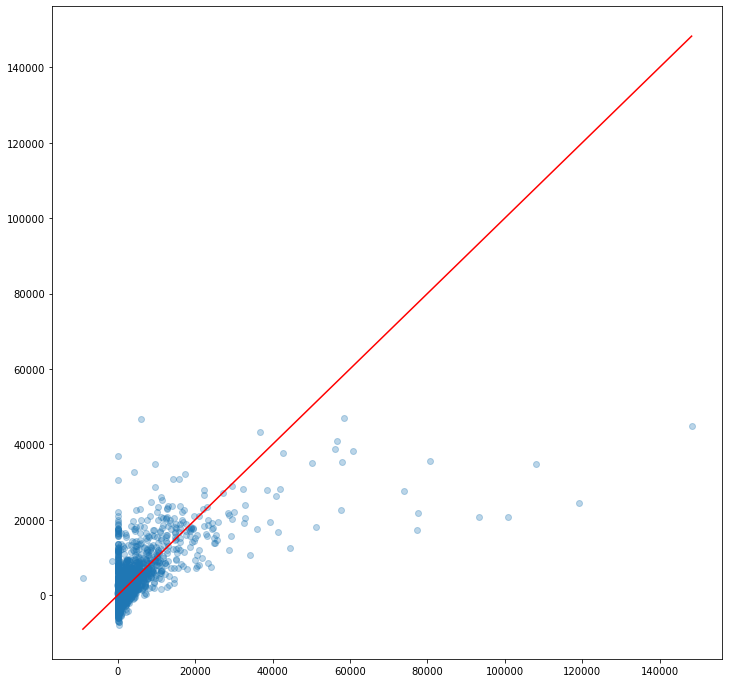

In [55]:
fig, ax = graph_true_vs_predict(y_val, y_val_pred)

The R<sup>2</sup> is 0.415, which suggests that these combined features are useful but not entirely predictive of the case rate. This is perhaps not too surprising, as there are other important aspects that would influence the relationship between searches and cases, including the state, the date, and the demographic information. At the very least, this is useful to verify that our search information will aid our model, and it provides a benchmark for us to beat later.

The scatterplot shows that there are a bunch of '0' values, as expected. However, the linear regression appears to poorly predict when the case rates are low. This may be because google search trends are reported daily, while cases and deaths are not reported on the weekends for many states. I will keep this in the back of my mind as I continue. 

It seems like the relationship between symptom searches and cases is nonlinear, and there is a strong right skew to our data (many low case values, few high case values). To redo this sort of non-time-series analysis, we may need to upsample our observations with higher case reports, and downsample our 0's. Either that, or we will need to perform some sort of boosting.

### A Pseudo-Autoregressive Linear Model

The key reason to use any time series model is *autoregression* -- that is, predicted values are at least partially dependent on the value of the previous timepoint. Let's add the previous time point as a feature on the linear model to see whether it improves the prediction.

#### Helper Functions

In [73]:
def graph_true_vs_predict(y_val, y_pred):
    fig, ax = plt.subplots(figsize=(12,12))

    x = np.linspace(y_val.min(), y_val.max(), 2)
    y = x

    ax.scatter(y_val, y_pred, alpha = 0.3)
    ax.plot(x, y, '-r')
    
    ax.set_xlabel("True Values")
    ax.set_ylabel("Predicted Values")
    
    return fig, ax

def R2_val(y_val, y_pred):
    y_var = (y_val - y_val.mean()) ** 2
    TSS = y_var.sum()
    
    y_res = (y_val - y_pred) ** 2 
    RSS = y_res.sum()
    
    R2 = 1 - (RSS/TSS)
    
    return R2

def RMSE_val(y_val, y_pred):
    RSS = ((y_val - y_pred) ** 2).sum()
    var = RSS / y_val.shape[0]
    RMSE = var ** (1/2)
    
    return RMSE

#### Creating a New Dataframe with Previous Time Point

In [107]:
test_df_cut = pd.read_csv("COVID19_cases_searches_naiveLR.csv")
test_df_cut.head()

,state,date,cases,symptom:Stroke,symptom:Eye strain,symptom:Indigestion,symptom:Tenderness,symptom:Angioedema,symptom:Pleurisy,symptom:Middle back pain,...,symptom:Common cold,symptom:Phlegm,symptom:Pneumonia,symptom:Shivering,symptom:Sputum,symptom:Hypoxemia,symptom:Chills,total_distributed,symptom:Fever,symptom:Low-grade fever
0,Alabama,2021-01-12,3848,2.60,0.29,1.52,0.11,0.18,0.20,0.38,...,9.75,0.63,1.67,0.26,0.20,0.70,0.31,377025.0,3.88,0.28
1,Alabama,2021-01-13,3147,2.71,0.26,1.57,0.15,0.18,0.25,0.37,...,9.62,0.57,1.56,0.23,0.17,0.73,0.34,378975.0,3.92,0.27
2,Alabama,2021-01-14,3588,2.64,0.31,1.66,0.15,0.18,0.21,0.41,...,9.36,0.59,1.63,0.21,0.15,0.76,0.31,435350.0,4.06,0.28
3,Alabama,2021-01-15,2945,2.52,0.27,1.55,0.16,0.15,0.19,0.36,...,9.17,0.64,1.59,0.21,0.16,0.71,0.30,444650.0,3.81,0.27
4,Alabama,2021-01-16,3153,2.30,0.27,1.67,0.14,0.24,0.20,0.38,...,9.73,0.65,1.28,0.26,0.14,0.73,0.30,444650.0,3.78,0.26


In [108]:
test_df_cut3 = test_df_cut.copy()
test_df_cut3['date'] = np.vectorize(pd.to_datetime)(test_df_cut3['date'])
test_df_cut3['yesterday'] = test_df_cut3['date'] - timedelta(days=1)
test_df_cut3 = test_df_cut3.set_index(['state', 'date', 'cases', 'yesterday']).reset_index()
test_df_cut3 = test_df_cut3.set_index(['state','date'])
test_df_cut3['yesterday_val'] = -1

test_df_cut3.head()

cases  yesterday  symptom:Stroke  symptom:Eye strain  \
state   date                                                               
Alabama 2021-01-12   3848 2021-01-11            2.60                0.29   
        2021-01-13   3147 2021-01-12            2.71                0.26   
        2021-01-14   3588 2021-01-13            2.64                0.31   
        2021-01-15   2945 2021-01-14            2.52                0.27   
        2021-01-16   3153 2021-01-15            2.30                0.27   

                    symptom:Indigestion  symptom:Tenderness  \
state   date                                                  
Alabama 2021-01-12                 1.52                0.11   
        2021-01-13                 1.57                0.15   
        2021-01-14                 1.66                0.15   
        2021-01-15                 1.55                0.16   
        2021-01-16                 1.67                0.14   

                    symptom:Angioedema  symptom:Pleurisy  \
state   date                                               
Alabama 2021-01-12                0.18              0.20   
        2021-01-13                0.18              0.25   
        2021-01-14                0.18              0.21   
        2021-01-15                0.15              0.19   
        2021-01-16                0.24              0.20   

                    symptom:Middle back pain  symptom:Pleural effusion  ...  \
state   date                                                            ...   
Alabama 2021-01-12                      0.38                      0.22  ...   
        2021-01-13                      0.37                      0.23  ...   
        2021-01-14                      0.41                      0.29  ...   
        2021-01-15                      0.36                      0.30  ...   
        2021-01-16                      0.38                      0.17  ...   

                    symptom:Phlegm  symptom:Pneumonia  symptom:Shivering  \
state   date                                                               
Alabama 2021-01-12            0.63               1.67               0.26   
        2021-01-13            0.57               1.56               0.23   
        2021-01-14            0.59               1.63               0.21   
        2021-01-15            0.64               1.59               0.21   
        2021-01-16            0.65               1.28               0.26   

                    symptom:Sputum  symptom:Hypoxemia  symptom:Chills  \
state   date                                                            
Alabama 2021-01-12            0.20               0.70            0.31   
        2021-01-13            0.17               0.73            0.34   
        2021-01-14            0.15               0.76            0.31   
        2021-01-15            0.16               0.71            0.30   
        2021-01-16            0.14               0.73            0.30   

                    total_distributed  symptom:Fever  symptom:Low-grade fever  \
state   date                                                                    
Alabama 2021-01-12           377025.0           3.88                     0.28   
        2021-01-13           378975.0           3.92                     0.27   
        2021-01-14           435350.0           4.06                     0.28   
        2021-01-15           444650.0           3.81                     0.27   
        2021-01-16           444650.0           3.78                     0.26   

                    yesterday_val  
state   date                       
Alabama 2021-01-12             -1  
        2021-01-13             -1  
        2021-01-14             -1  
        2021-01-15             -1  
        2021-01-16             -1  

[5 rows x 78 columns]

In [109]:
for i in range(0, test_df_cut3.shape[0]):
    state = test_df_cut3.index[i][0]
    yesterday_date = test_df_cut3.iloc[i,1].date()
    date = str(pd.to_datetime(yesterday_date + timedelta(days=1)).date())
    yesterday_date = str(yesterday_date)
    if yesterday_date == '2021-01-11':
        test_df_cut3['yesterday_val'][i] = test_df_cut3.loc[state, date]['cases']
    else:
        test_df_cut3['yesterday_val'][i] = test_df_cut3.loc[state, yesterday_date]['cases']

test_df_cut3.head()

/tmp/ipykernel_471/1511630002.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_cut3['yesterday_val'][i] = test_df_cut3.loc[state, date]['cases']
/tmp/ipykernel_471/1511630002.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_cut3['yesterday_val'][i] = test_df_cut3.loc[state, yesterday_date]['cases']


cases  yesterday  symptom:Stroke  symptom:Eye strain  \
state   date                                                               
Alabama 2021-01-12   3848 2021-01-11            2.60                0.29   
        2021-01-13   3147 2021-01-12            2.71                0.26   
        2021-01-14   3588 2021-01-13            2.64                0.31   
        2021-01-15   2945 2021-01-14            2.52                0.27   
        2021-01-16   3153 2021-01-15            2.30                0.27   

                    symptom:Indigestion  symptom:Tenderness  \
state   date                                                  
Alabama 2021-01-12                 1.52                0.11   
        2021-01-13                 1.57                0.15   
        2021-01-14                 1.66                0.15   
        2021-01-15                 1.55                0.16   
        2021-01-16                 1.67                0.14   

                    symptom:Angioedema  symptom:Pleurisy  \
state   date                                               
Alabama 2021-01-12                0.18              0.20   
        2021-01-13                0.18              0.25   
        2021-01-14                0.18              0.21   
        2021-01-15                0.15              0.19   
        2021-01-16                0.24              0.20   

                    symptom:Middle back pain  symptom:Pleural effusion  ...  \
state   date                                                            ...   
Alabama 2021-01-12                      0.38                      0.22  ...   
        2021-01-13                      0.37                      0.23  ...   
        2021-01-14                      0.41                      0.29  ...   
        2021-01-15                      0.36                      0.30  ...   
        2021-01-16                      0.38                      0.17  ...   

                    symptom:Phlegm  symptom:Pneumonia  symptom:Shivering  \
state   date                                                               
Alabama 2021-01-12            0.63               1.67               0.26   
        2021-01-13            0.57               1.56               0.23   
        2021-01-14            0.59               1.63               0.21   
        2021-01-15            0.64               1.59               0.21   
        2021-01-16            0.65               1.28               0.26   

                    symptom:Sputum  symptom:Hypoxemia  symptom:Chills  \
state   date                                                            
Alabama 2021-01-12            0.20               0.70            0.31   
        2021-01-13            0.17               0.73            0.34   
        2021-01-14            0.15               0.76            0.31   
        2021-01-15            0.16               0.71            0.30   
        2021-01-16            0.14               0.73            0.30   

                    total_distributed  symptom:Fever  symptom:Low-grade fever  \
state   date                                                                    
Alabama 2021-01-12           377025.0           3.88                     0.28   
        2021-01-13           378975.0           3.92                     0.27   
        2021-01-14           435350.0           4.06                     0.28   
        2021-01-15           444650.0           3.81                     0.27   
        2021-01-16           444650.0           3.78                     0.26   

                    yesterday_val  
state   date                       
Alabama 2021-01-12           3848  
        2021-01-13           3848  
        2021-01-14           3147  
        2021-01-15           3588  
        2021-01-16           2945  

[5 rows x 78 columns]

In [113]:
df = test_df_cut3.copy().reset_index().set_index(['state', 'date']).reset_index()

In [114]:
df.to_csv("COVID19_cases_searches_autocorrelatedLR.csv", index=False)

#### Fitting the "Pseudo-autocorrelated" Linear Regression

Now, let's re-split the new dataframe and fit a multiple linear model to the data.

In [116]:
df_yesterdayVal = pd.read_csv("COVID19_cases_searches_autocorrelatedLR.csv").drop(['yesterday', 'state', 'date'], axis=1)
df_yesterdayVal = df_yesterdayVal.reset_index(drop=True).set_index(['cases', 'yesterday_val']).reset_index()
df_yesterdayVal.head()

,cases,yesterday_val,symptom:Stroke,symptom:Eye strain,symptom:Indigestion,symptom:Tenderness,symptom:Angioedema,symptom:Pleurisy,symptom:Middle back pain,symptom:Pleural effusion,...,symptom:Common cold,symptom:Phlegm,symptom:Pneumonia,symptom:Shivering,symptom:Sputum,symptom:Hypoxemia,symptom:Chills,total_distributed,symptom:Fever,symptom:Low-grade fever
0,3848,3848,2.60,0.29,1.52,0.11,0.18,0.20,0.38,0.22,...,9.75,0.63,1.67,0.26,0.20,0.70,0.31,377025.0,3.88,0.28
1,3147,3848,2.71,0.26,1.57,0.15,0.18,0.25,0.37,0.23,...,9.62,0.57,1.56,0.23,0.17,0.73,0.34,378975.0,3.92,0.27
2,3588,3147,2.64,0.31,1.66,0.15,0.18,0.21,0.41,0.29,...,9.36,0.59,1.63,0.21,0.15,0.76,0.31,435350.0,4.06,0.28
3,2945,3588,2.52,0.27,1.55,0.16,0.15,0.19,0.36,0.30,...,9.17,0.64,1.59,0.21,0.16,0.71,0.30,444650.0,3.81,0.27
4,3153,2945,2.30,0.27,1.67,0.14,0.24,0.20,0.38,0.17,...,9.73,0.65,1.28,0.26,0.14,0.73,0.30,444650.0,3.78,0.26


In [117]:
X_train, X_val, y_train, y_val = train_test_split(df_yesterdayVal.drop("cases", axis=1),
                                                  df_yesterdayVal["cases"],
                                                  test_size=0.2,
                                                  random_state=1)

mlr = LinearRegression()
mlr.fit(X_train, y_train)

LinearRegression()

In [118]:
y_val_pred = mlr.predict(X_val)

In [119]:
mse_auto = RMSE_val(y_val, y_val_pred)
r2_auto = R2_val(y_val, y_val_pred)
print(f"RMSE: {mse_auto}; R2: {r2_auto}")

RMSE: 6146.785778527083; R2: 0.4593437816579442


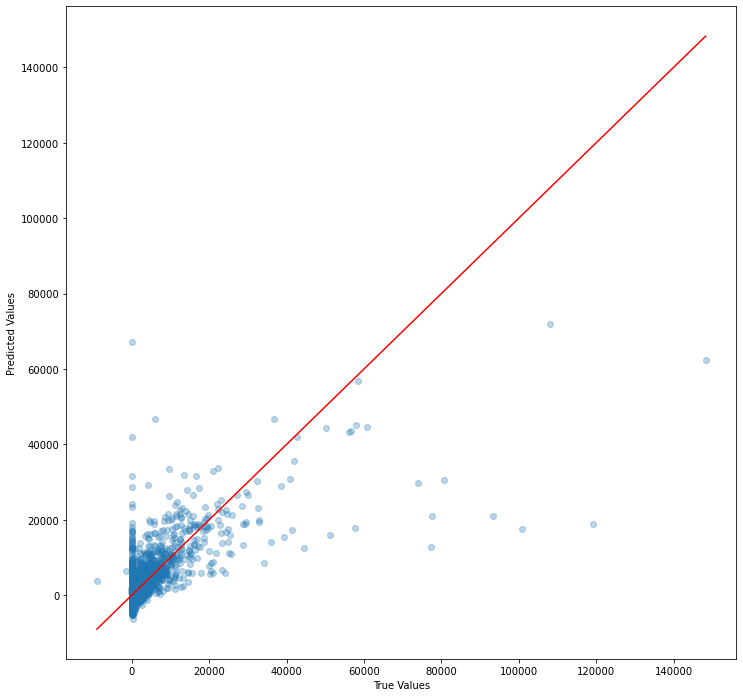

In [120]:
fig, ax = graph_true_vs_predict(y_val, y_val_pred)

So, the R<sup>2</sup> is greater than the previous (0.41). Next, we'll remove the yesterday_val column and retrain the model so that we can see the difference.

I am still seeing that the linear regression is highly affected by the few high-cases values, and most large mispredictions appear to be when actual cases = 0. Chances are that this is because of a state-wide lapse on reporting over the weekends.

#### Comparing to a model on the same dataset, without the previous cases feature...

In [80]:
X_train, X_val, y_train, y_val = train_test_split(df_yesterdayVal.drop(["cases",'yesterday_val'], axis=1),
                                                  df_yesterdayVal["cases"],
                                                  test_size=0.2,
                                                  random_state=1)

mlr_noAutoRegression = LinearRegression()
mlr_noAutoRegression.fit(X_train, y_train)

LinearRegression()

In [81]:
y_val_pred = mlr_noAutoRegression.predict(X_val)

In [82]:
rmse = RMSE_val(y_val, y_val_pred)
r2 = R2_val(y_val, y_val_pred)
print(f"RMSE: {rmse}; R^2: {r2}")

RMSE: 6391.95916689358; R^2: 0.415353935384008


In [83]:
### comparing to the previous model with pseudo-autoregression:
print(f"MSE: {mse_auto}; R2: {r2_auto}")

MSE: 6146.785778527083; R2: 0.4593437816579442


The model with pseudo-autoregression does indeed look better.

### Dimensionality Reduction: Helpful?

Finally, since the google search trends are highly correlated with each other, let's perform dimensionality reduction to summarize these into a smaller number of features, and see if it improves the model.

#### Transforming Dimensions

In [38]:
df_yesterdayVal.head()

,cases,yesterday_val,symptom:Stroke,symptom:Eye strain,symptom:Indigestion,symptom:Tenderness,symptom:Angioedema,symptom:Pleurisy,symptom:Middle back pain,symptom:Pleural effusion,...,symptom:Common cold,symptom:Phlegm,symptom:Pneumonia,symptom:Shivering,symptom:Sputum,symptom:Hypoxemia,symptom:Chills,total_distributed,symptom:Fever,symptom:Low-grade fever
0,3848,3848,2.60,0.29,1.52,0.11,0.18,0.20,0.38,0.22,...,9.75,0.63,1.67,0.26,0.20,0.70,0.31,377025.0,3.88,0.28
1,3147,3848,2.71,0.26,1.57,0.15,0.18,0.25,0.37,0.23,...,9.62,0.57,1.56,0.23,0.17,0.73,0.34,378975.0,3.92,0.27
2,3588,3147,2.64,0.31,1.66,0.15,0.18,0.21,0.41,0.29,...,9.36,0.59,1.63,0.21,0.15,0.76,0.31,435350.0,4.06,0.28
3,2945,3588,2.52,0.27,1.55,0.16,0.15,0.19,0.36,0.30,...,9.17,0.64,1.59,0.21,0.16,0.71,0.30,444650.0,3.81,0.27
4,3153,2945,2.30,0.27,1.67,0.14,0.24,0.20,0.38,0.17,...,9.73,0.65,1.28,0.26,0.14,0.73,0.30,444650.0,3.78,0.26


In [39]:
df_yesterdayVal.shape

(12180, 77)

In [89]:
scaler = StandardScaler()
symptoms = scaler.fit_transform(df_yesterdayVal.drop(['cases', 'yesterday_val'], axis=1))
symptoms

array([[ 0.16440738,  1.21143294,  0.54144734, ..., -0.87476411,
         0.14318761,  0.58522188],
       [ 0.39373421,  0.6340184 ,  0.78763143, ..., -0.87460466,
         0.18190866,  0.49332658],
       [ 0.24779895,  1.59637597,  1.23076278, ..., -0.86999499,
         0.31743233,  0.58522188],
       ...,
       [-0.96137887, -1.09822524,  0.39373689, ...,  0.00357195,
        -0.77643731, -0.60941697],
       [-0.89883519, -1.29069675,  0.83686824, ...,  0.00357195,
        -0.72803599, -0.79320757],
       [ 0.39373421, -0.52081069,  0.29526325, ...,  0.00357195,
        -0.56347154, -0.51752168]])

In [90]:
pd.DataFrame(symptoms).shape

(12180, 75)

In [91]:
PCA_model = PCA(n_components = 0.99, svd_solver='full', random_state=42)

symptoms_reduced = PCA_model.fit_transform(symptoms)
pd.DataFrame(symptoms_reduced)

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,4.053560,-2.700041,-2.284608,4.942385,1.635590,1.023781,1.232463,1.744645,0.412867,-0.070500,...,0.609683,0.251215,-0.007384,-0.002533,0.249602,-0.440434,0.068243,0.134150,0.475602,0.277588
1,4.892441,-3.205614,-2.037197,4.948722,0.768236,1.826688,1.543968,1.434465,0.069210,-0.450154,...,0.043990,0.139885,-0.025825,0.074080,-0.033181,-0.166354,-0.243129,-0.235045,0.064831,0.998404
2,5.585716,-4.370715,-2.058669,5.038309,0.686245,0.824234,1.295779,0.985054,1.104043,0.522380,...,-0.169733,0.433852,-0.247609,0.013361,-0.020977,0.012738,-0.289296,-0.135274,0.508360,0.547310
3,2.856177,-2.335473,-1.799318,5.238215,0.079485,0.892549,1.857924,0.868803,0.371301,-0.569637,...,-0.082733,-0.019867,0.306139,0.393464,-0.040515,-0.157594,-0.161277,0.281409,0.167644,0.528260
4,4.255562,-2.386167,1.367315,6.514948,-1.386676,1.863909,0.962640,0.847513,1.012597,-0.392493,...,0.702381,0.165902,0.032192,0.352266,0.267538,-0.771010,-0.124425,0.028305,-0.244993,0.056356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12175,-1.141855,-0.158200,-0.363326,-2.617517,-0.370583,1.792130,-0.823626,0.425746,0.359814,-0.056566,...,-0.339683,-0.338442,0.402259,-0.611740,-0.365138,-0.215542,-0.300425,-0.134292,-0.172334,-0.044713
12176,-4.433438,1.824651,-0.588384,-2.060923,-0.913058,1.512949,0.424039,0.113313,0.514374,-0.335115,...,0.119006,-0.335396,0.173176,-0.455725,-0.341715,0.095271,-0.168856,-0.113933,-0.096613,-0.063715
12177,-4.819128,2.747649,1.793261,-0.405320,-2.344527,1.752137,-0.310856,0.335731,0.904737,-0.466253,...,-0.191125,0.163168,0.198082,0.160162,-0.359300,-0.249998,-0.240911,-0.237262,0.132678,0.195617
12178,-2.572964,1.569508,2.174764,-0.994683,-1.411891,1.941128,-0.222853,-0.541077,1.291253,0.144803,...,0.020846,0.047205,-0.592612,0.550590,-0.722397,0.433760,0.149884,0.346658,-0.067699,0.072949


In [92]:
## explained variance for each dimension of the PCA.
PCA_model.explained_variance_ratio_

array([0.42695553, 0.17662407, 0.06641827, 0.05382216, 0.03285188,
       0.02176889, 0.01979483, 0.01367557, 0.01348862, 0.01217098,
       0.0098653 , 0.0085892 , 0.00831802, 0.00710503, 0.00667397,
       0.00640445, 0.00603871, 0.00571159, 0.0054686 , 0.00532067,
       0.00483134, 0.00436502, 0.00431332, 0.00417227, 0.00394536,
       0.00378818, 0.00358916, 0.00348121, 0.00336263, 0.00314683,
       0.00302037, 0.00291779, 0.00276   , 0.00263545, 0.0025649 ,
       0.00247622, 0.00239795, 0.00234732, 0.00224094, 0.00209398,
       0.00193617, 0.00183301, 0.00176878, 0.00164064, 0.00156432,
       0.00146286, 0.00136375, 0.00131594, 0.00123909, 0.00113562,
       0.00107564, 0.00105332, 0.00098884, 0.00090642])

In [93]:
df_yesterdayVal_symptomReduced = df_yesterdayVal[["cases","yesterday_val"]].merge(pd.DataFrame(symptoms_reduced),
                                                                                  left_index=True,
                                                                                  right_index=True,
                                                                                  how='left')
df_yesterdayVal_symptomReduced

,cases,yesterday_val,0,1,2,3,4,5,6,7,...,44,45,46,47,48,49,50,51,52,53
0,3848,3848,4.053560,-2.700041,-2.284608,4.942385,1.635590,1.023781,1.232463,1.744645,...,0.609683,0.251215,-0.007384,-0.002533,0.249602,-0.440434,0.068243,0.134150,0.475602,0.277588
1,3147,3848,4.892441,-3.205614,-2.037197,4.948722,0.768236,1.826688,1.543968,1.434465,...,0.043990,0.139885,-0.025825,0.074080,-0.033181,-0.166354,-0.243129,-0.235045,0.064831,0.998404
2,3588,3147,5.585716,-4.370715,-2.058669,5.038309,0.686245,0.824234,1.295779,0.985054,...,-0.169733,0.433852,-0.247609,0.013361,-0.020977,0.012738,-0.289296,-0.135274,0.508360,0.547310
3,2945,3588,2.856177,-2.335473,-1.799318,5.238215,0.079485,0.892549,1.857924,0.868803,...,-0.082733,-0.019867,0.306139,0.393464,-0.040515,-0.157594,-0.161277,0.281409,0.167644,0.528260
4,3153,2945,4.255562,-2.386167,1.367315,6.514948,-1.386676,1.863909,0.962640,0.847513,...,0.702381,0.165902,0.032192,0.352266,0.267538,-0.771010,-0.124425,0.028305,-0.244993,0.056356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12175,576,781,-1.141855,-0.158200,-0.363326,-2.617517,-0.370583,1.792130,-0.823626,0.425746,...,-0.339683,-0.338442,0.402259,-0.611740,-0.365138,-0.215542,-0.300425,-0.134292,-0.172334,-0.044713
12176,542,576,-4.433438,1.824651,-0.588384,-2.060923,-0.913058,1.512949,0.424039,0.113313,...,0.119006,-0.335396,0.173176,-0.455725,-0.341715,0.095271,-0.168856,-0.113933,-0.096613,-0.063715
12177,0,542,-4.819128,2.747649,1.793261,-0.405320,-2.344527,1.752137,-0.310856,0.335731,...,-0.191125,0.163168,0.198082,0.160162,-0.359300,-0.249998,-0.240911,-0.237262,0.132678,0.195617
12178,0,0,-2.572964,1.569508,2.174764,-0.994683,-1.411891,1.941128,-0.222853,-0.541077,...,0.020846,0.047205,-0.592612,0.550590,-0.722397,0.433760,0.149884,0.346658,-0.067699,0.072949


#### Running Model on Dataframe with Reduced Dimensions

In [94]:
X_train, X_val, y_train, y_val = train_test_split(df_yesterdayVal_symptomReduced.drop(["cases",'yesterday_val'], axis=1),
                                                  df_yesterdayVal_symptomReduced["cases"],
                                                  test_size=0.2,
                                                  random_state=1)

mlr_reduced = LinearRegression()
mlr_reduced.fit(X_train, y_train)

LinearRegression()

In [95]:
y_val_pred = mlr_reduced.predict(X_val)

In [96]:
rmse = RMSE_val(y_val, y_val_pred)
r2 = R2_val(y_val, y_val_pred)
print(f"RMSE: {rmse}; R^2: {r2}")

RMSE: 6474.766272237641; R^2: 0.4001077679833962


Explained variance went down in this case, which is pretty surprising to me. This suggests that while features are correlated, modeling the variance of correlated features doesn't help the linear model fit better to the test data. Perhaps this will be different for a lower-bias model.

### One Final Linear Model: Adding Day of the Week as Feature

Finally, our EDA found that there is cyclical structure to the time series -- certain days of the week have no reporting of cases and deaths. Let's add the day of the week to the model to see how it improves a simple regression.

#### Adding Day of the Week as One-Hot Encoded Feature:

In [128]:
date_cols = ['date', 'yesterday']
df = pd.read_csv("COVID19_cases_searches_autocorrelatedLR.csv", parse_dates = date_cols)
df = df.drop('yesterday', axis=1).set_index(['state', 'date'])
df.head()

cases  symptom:Stroke  symptom:Eye strain  \
state   date                                                    
Alabama 2021-01-12   3848            2.60                0.29   
        2021-01-13   3147            2.71                0.26   
        2021-01-14   3588            2.64                0.31   
        2021-01-15   2945            2.52                0.27   
        2021-01-16   3153            2.30                0.27   

                    symptom:Indigestion  symptom:Tenderness  \
state   date                                                  
Alabama 2021-01-12                 1.52                0.11   
        2021-01-13                 1.57                0.15   
        2021-01-14                 1.66                0.15   
        2021-01-15                 1.55                0.16   
        2021-01-16                 1.67                0.14   

                    symptom:Angioedema  symptom:Pleurisy  \
state   date                                               
Alabama 2021-01-12                0.18              0.20   
        2021-01-13                0.18              0.25   
        2021-01-14                0.18              0.21   
        2021-01-15                0.15              0.19   
        2021-01-16                0.24              0.20   

                    symptom:Middle back pain  symptom:Pleural effusion  \
state   date                                                             
Alabama 2021-01-12                      0.38                      0.22   
        2021-01-13                      0.37                      0.23   
        2021-01-14                      0.41                      0.29   
        2021-01-15                      0.36                      0.30   
        2021-01-16                      0.38                      0.17   

                    symptom:Delayed onset muscle soreness  ...  \
state   date                                               ...   
Alabama 2021-01-12                                   0.50  ...   
        2021-01-13                                   0.54  ...   
        2021-01-14                                   0.63  ...   
        2021-01-15                                   0.52  ...   
        2021-01-16                                   0.50  ...   

                    symptom:Phlegm  symptom:Pneumonia  symptom:Shivering  \
state   date                                                               
Alabama 2021-01-12            0.63               1.67               0.26   
        2021-01-13            0.57               1.56               0.23   
        2021-01-14            0.59               1.63               0.21   
        2021-01-15            0.64               1.59               0.21   
        2021-01-16            0.65               1.28               0.26   

                    symptom:Sputum  symptom:Hypoxemia  symptom:Chills  \
state   date                                                            
Alabama 2021-01-12            0.20               0.70            0.31   
        2021-01-13            0.17               0.73            0.34   
        2021-01-14            0.15               0.76            0.31   
        2021-01-15            0.16               0.71            0.30   
        2021-01-16            0.14               0.73            0.30   

                    total_distributed  symptom:Fever  symptom:Low-grade fever  \
state   date                                                                    
Alabama 2021-01-12           377025.0           3.88                     0.28   
        2021-01-13           378975.0           3.92                     0.27   
        2021-01-14           435350.0           4.06                     0.28   
        2021-01-15           444650.0           3.81                     0.27   
        2021-01-16           444650.0           3.78                     0.26   

                    yesterday_val  
state   date                       
Alabama 2021-01-12           3848 

In [129]:
df['day_of_week'] = df.index.get_level_values('date').day_name()

In [130]:
df = df.reset_index()

In [131]:
# We need to one-hot encode day_of_week

ohe = OneHotEncoder()

series = ohe.fit_transform(df[['day_of_week']])
series = series.toarray()
series

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [132]:
series = pd.DataFrame(series, columns = ['col1', 'col2', 'col3', 'col4',
                                         'col5', 'col6', 'col7'])

df_ohe = df.merge(series, left_index=True, right_index=True, how='outer')
df_ohe.head()

,state,date,cases,symptom:Stroke,symptom:Eye strain,symptom:Indigestion,symptom:Tenderness,symptom:Angioedema,symptom:Pleurisy,symptom:Middle back pain,...,symptom:Low-grade fever,yesterday_val,day_of_week,col1,col2,col3,col4,col5,col6,col7
0,Alabama,2021-01-12,3848,2.60,0.29,1.52,0.11,0.18,0.20,0.38,...,0.28,3848,Tuesday,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Alabama,2021-01-13,3147,2.71,0.26,1.57,0.15,0.18,0.25,0.37,...,0.27,3848,Wednesday,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,Alabama,2021-01-14,3588,2.64,0.31,1.66,0.15,0.18,0.21,0.41,...,0.28,3147,Thursday,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,Alabama,2021-01-15,2945,2.52,0.27,1.55,0.16,0.15,0.19,0.36,...,0.27,3588,Friday,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Alabama,2021-01-16,3153,2.30,0.27,1.67,0.14,0.24,0.20,0.38,...,0.26,2945,Saturday,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [133]:
day_dict = {'col1': 'Friday', 'col2': 'Monday', 'col3': 'Saturday',
            'col4': 'Sunday', 'col5': 'Thursday', 'col6': 'Tuesday',
            'col7': 'Wednesday'}
df_ohe.rename(columns = day_dict, inplace=True)
df_ohe.drop('day_of_week', inplace=True, axis=1)
df_ohe.head()

,state,date,cases,symptom:Stroke,symptom:Eye strain,symptom:Indigestion,symptom:Tenderness,symptom:Angioedema,symptom:Pleurisy,symptom:Middle back pain,...,symptom:Fever,symptom:Low-grade fever,yesterday_val,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,Alabama,2021-01-12,3848,2.60,0.29,1.52,0.11,0.18,0.20,0.38,...,3.88,0.28,3848,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Alabama,2021-01-13,3147,2.71,0.26,1.57,0.15,0.18,0.25,0.37,...,3.92,0.27,3848,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,Alabama,2021-01-14,3588,2.64,0.31,1.66,0.15,0.18,0.21,0.41,...,4.06,0.28,3147,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,Alabama,2021-01-15,2945,2.52,0.27,1.55,0.16,0.15,0.19,0.36,...,3.81,0.27,3588,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Alabama,2021-01-16,3153,2.30,0.27,1.67,0.14,0.24,0.20,0.38,...,3.78,0.26,2945,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [136]:
df_ohe.to_csv("COVID19_cases_searches_dayOfWeek.csv", index=False, sep=',')

#### Running Linear Model with Day of the Week

In [203]:
df_ohe = pd.read_csv("COVID19_cases_searches_dayOfWeek.csv", sep=',')
df_ohe_anon = df_ohe.drop(['state', 'date'], axis=1)

# One last thing: there are days with negative cases, which simply don't make sense. Since these models are not using time series yet, let's remove these observations.

df_ohe_anon = df_ohe_anon[df_ohe_anon['cases'] >= 0]
df_ohe_anon.shape

(12158, 84)

In [204]:
X_train, X_val, y_train, y_val = train_test_split(df_ohe_anon.drop("cases", axis=1),
                                                  df_ohe_anon["cases"],
                                                  test_size=0.2,
                                                  random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((9726, 83), (2432, 83), (9726,), (2432,))

In [205]:
mlr_dayOHE = LinearRegression()
mlr_dayOHE.fit(X_train, y_train)

LinearRegression()

In [206]:
y_val_pred = mlr_dayOHE.predict(X_val)

In [207]:
rmse = RMSE_val(y_val, y_val_pred)
r2 = R2_val(y_val, y_val_pred)
print(f"RMSE: {rmse}; R^2: {r2}")

RMSE: 7500.723478392819; R^2: 0.4712844705473598


Encoding the days of the week increased the R<sup>2</sup> value. I will need the adjusted R<sup>2</sup> value to compare models (or better yet, the AIC and BIC) but I am pretty sure this increase is significant even when comparing an 84-parameter model against a 77-parameter model.

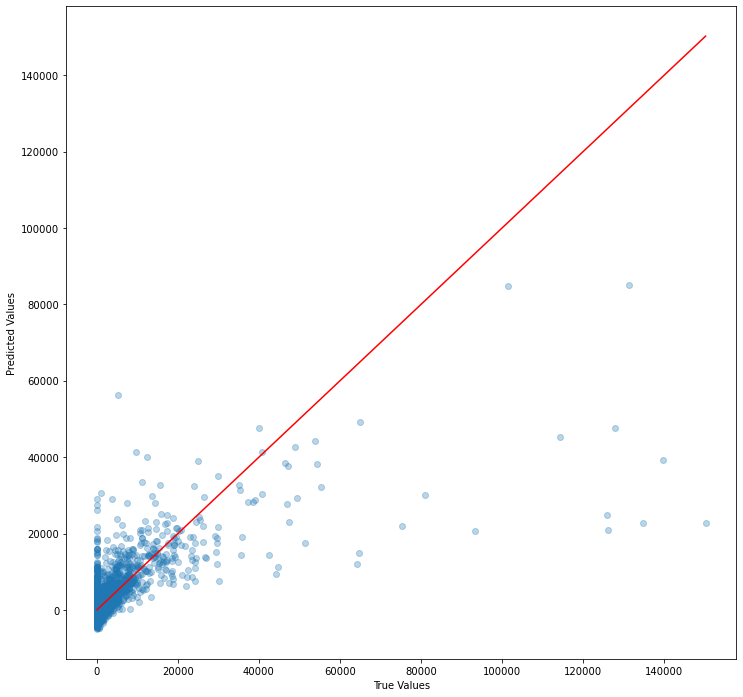

In [208]:
fig, ax = graph_true_vs_predict(y_val, y_val_pred)

Finally, I can see that the real y_val is highly skewed to the right. I suspect the y_train is the same way, so let's try rescaling them via the log function.

Just for my information, I will also plot the residuals to see if there is any distribution to them.

In [210]:
residuals = y_val - y_val_pred

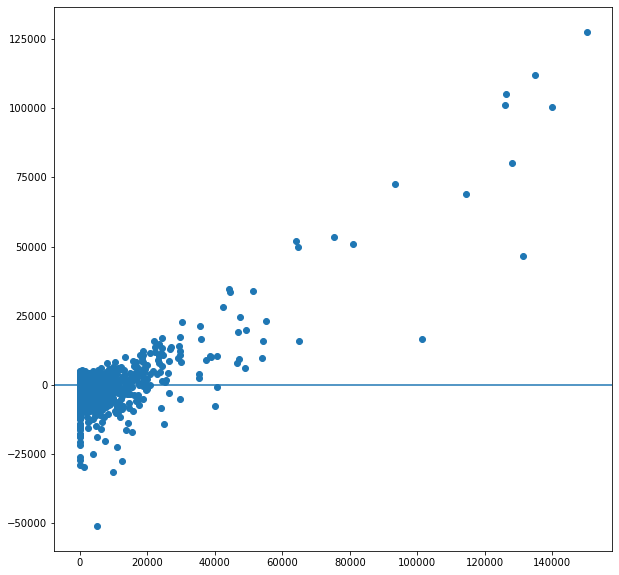

In [213]:
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(y_val, residuals)

ax.axhline(0)

#### Linear Regression on Log-Scale Cases

In [168]:
y_val_log = np.log(y_val + 1)
y_train_log = np.log(y_train + 1)

In [169]:
mlr_dayOHE_logScale = LinearRegression()
mlr_dayOHE_logScale.fit(X_train, y_train_log)

LinearRegression()

In [170]:
y_val_pred_log = mlr_dayOHE_logScale.predict(X_val)

In [184]:
rmse = RMSE_val(y_val_log, y_val_pred_log)
r2 = R2_val(y_val_log, y_val_pred_log)
print(f"MSE: {rmse}; R^2: {r2}")

MSE: 2.2839958815136816; R^2: 0.418155443631266


In [185]:
y_val_pred_log.max()

22.714366931690677

In [186]:
y_val_log.max()

11.920069163456947

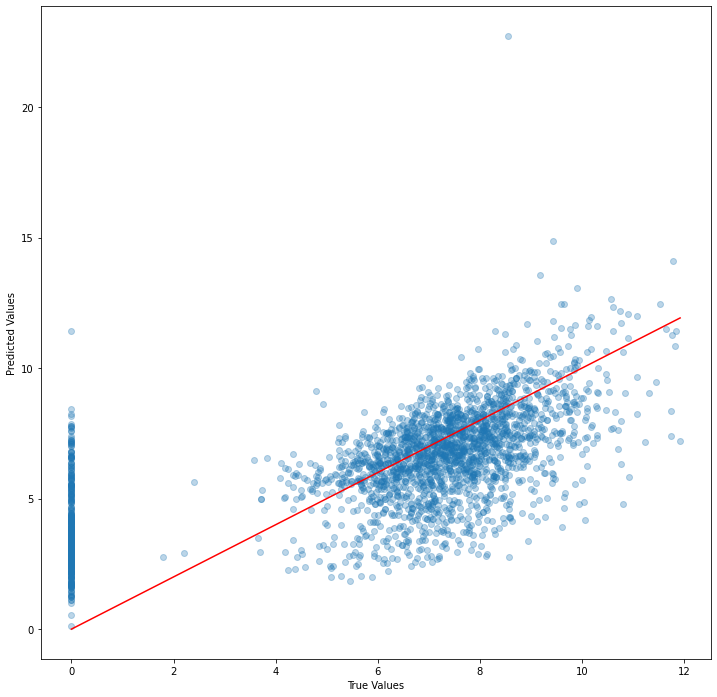

In [189]:
fig, ax = graph_true_vs_predict(y_val_log, y_val_pred_log)

The fit does look better after all, but the MSE is highly increased by the large number of 0 values.

## A "Medium Strength" Model: Boosted Trees or SVM to address nonlinearity in correlation?

We need a regression model that can more powerfully represent non-linear relationships between features, can include categorical features, and ideally does not require attention-based autoregression (which I would like to save for a stronger model such as LSTM, and only if necessary!). A few options immediately come to mind:
1. Generalized Additive Models, which does not assume a linear relationship but does assume a *smooth* relationship between features and outcome.
2. Boosted Trees, which does not assume a smooth relationship between inputs and output but is significantly more difficult to interpret.
3. SVM with a kernel, though I'm not sure what kernel would be best.

Unfortunately, GAMs are extremely hard to fit with the number of features I have, so I'll briefly try all of the other models.

#### Loading the Data

In [190]:
df_ohe = pd.read_csv("COVID19_cases_searches_dayOfWeek.csv", sep=',')
df_ohe.head()

,state,date,cases,symptom:Stroke,symptom:Eye strain,symptom:Indigestion,symptom:Tenderness,symptom:Angioedema,symptom:Pleurisy,symptom:Middle back pain,...,symptom:Fever,symptom:Low-grade fever,yesterday_val,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,Alabama,2021-01-12,3848,2.60,0.29,1.52,0.11,0.18,0.20,0.38,...,3.88,0.28,3848,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Alabama,2021-01-13,3147,2.71,0.26,1.57,0.15,0.18,0.25,0.37,...,3.92,0.27,3848,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,Alabama,2021-01-14,3588,2.64,0.31,1.66,0.15,0.18,0.21,0.41,...,4.06,0.28,3147,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,Alabama,2021-01-15,2945,2.52,0.27,1.55,0.16,0.15,0.19,0.36,...,3.81,0.27,3588,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Alabama,2021-01-16,3153,2.30,0.27,1.67,0.14,0.24,0.20,0.38,...,3.78,0.26,2945,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [191]:
df_ohe_anon = df_ohe.drop(['state', 'date'], axis=1)
df_ohe_anon = df_ohe_anon[df_ohe_anon['cases'] >= 0]
df_ohe_anon.shape

(12158, 84)

Now, to split the data and try a new linear regression:

In [10]:
X_train, X_val, y_train, y_val = train_test_split(df_ohe_anon.drop("cases", axis=1),
                                                  df_ohe_anon["cases"],
                                                  test_size=0.2,
                                                  random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((9726, 83), (2432, 83), (9726,), (2432,))

#### Making Helper Functions

In [188]:
def graph_true_vs_predict(y_val, y_pred):
    fig, ax = plt.subplots(figsize=(12,12))

    x = np.linspace(y_val.min(), y_val.max(), 2)
    y = x

    ax.scatter(y_val, y_pred, alpha = 0.3)
    ax.plot(x, y, '-r')
    
    ax.set_xlabel("True Values")
    ax.set_ylabel("Predicted Values")
    
    return fig, ax

def R2_val(y_val, y_pred):
    y_var = (y_val - y_val.mean()) ** 2
    TSS = y_var.sum()
    
    y_res = (y_val - y_pred) ** 2 
    RSS = y_res.sum()
    
    R2 = 1 - (RSS/TSS)
    
    return R2

def RMSE_val(y_val, y_pred):
    RSS = ((y_val - y_pred) ** 2).sum()
    var = RSS / y_val.shape[0]
    RMSE = var ** (1/2)
    
    return RMSE

### XGBoost: Regularized Gradient Boosted Trees

I have the highest hopes for this one -- let's see how it performs.

#### Out-of-the-Box: XGBoost with Default Parameters

First, we will use the default parameters to determine the base-level performance on our dataset.

In [198]:
params = {'max_depth': 6,
         'min_child_weight': 1,
         'eta': 0.3,
         'subsample': 1,
         'colsample_bytree': 1,
         'objective': 'reg:squarederror',
         'eval_metric': 'rmse'}
num_boost_round = 999

dtrain = xgb.DMatrix(data=X_train, label=y_train)

res = xgb.cv(params, dtrain, num_boost_round=num_boost_round, nfold=5,
             metrics={'rmse'}, seed=42,
             early_stopping_rounds=10,
             callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)])


res

[0]	train-rmse:7659.47627+512.64927	test-rmse:7904.20010+2291.53863
[1]	train-rmse:6084.97480+412.43660	test-rmse:6708.63740+2139.14959
[2]	train-rmse:4962.09590+345.86158	test-rmse:6089.86279+2078.00123
[3]	train-rmse:4151.95840+277.39303	test-rmse:5736.50913+2038.73857
[4]	train-rmse:3543.60625+236.74915	test-rmse:5482.93076+1970.25222
[5]	train-rmse:3091.76343+195.94496	test-rmse:5275.51060+1926.29012
[6]	train-rmse:2761.02324+161.64621	test-rmse:5199.51167+1885.56896
[7]	train-rmse:2534.98477+147.95364	test-rmse:5123.51235+1836.98167
[8]	train-rmse:2352.49087+131.71313	test-rmse:5089.21680+1827.59079
[9]	train-rmse:2220.35471+118.28159	test-rmse:5064.39292+1824.35642
[10]	train-rmse:2101.58611+120.17376	test-rmse:5058.72466+1815.62809
[11]	train-rmse:2003.84321+109.14521	test-rmse:5037.48579+1799.88053
[12]	train-rmse:1921.91716+99.45314	test-rmse:5040.60894+1806.04000
[13]	train-rmse:1872.57170+94.60701	test-rmse:5035.23149+1803.06927
[14]	train-rmse:1791.35149+86.29799	test-rmse:

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,7659.476270,512.649267,7904.200098,2291.538631
1,6084.974805,412.436604,6708.637403,2139.149591
2,4962.095898,345.861579,6089.862793,2078.001229
3,4151.958398,277.393027,5736.509131,2038.738573
4,3543.606250,236.749147,5482.930762,1970.252219
...,...,...,...,...
80,627.419470,30.930555,4929.606738,1752.686285
81,618.703430,33.672014,4929.015479,1752.727829
82,612.069885,31.220312,4929.561328,1752.635192
83,605.225818,30.014240,4928.982178,1753.099334


In [199]:
min_rmse = res['test-rmse-mean'].min()
min_rmse

4928.393506

In [200]:
xgb_tuned = xgb.XGBRegressor(n_estimators = 999, max_depth=params['max_depth'],
                             min_child_weight=params['min_child_weight'],
                             eta = params['eta'],
                             subsample = params['subsample'],
                             colsample_bytree = params['colsample_bytree'],
                             objective = params['objective'],
                             eval_metric = params['eval_metric'],
                             early_stopping_rounds=10, random_state=42)

xgb_tuned.fit(X_train, y_train)

[19:48:10] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
             enable_categorical=False, eta=0.3, eval_metric='rmse', gamma=0,
             gpu_id=-1, importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=999, n_jobs=12, num_parallel_tree=1, predictor='auto',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1, ...)

In [201]:
y_val_pred = xgb_tuned.predict(X_val)
y_val_pred

array([  800.5522  ,   -52.322308,  1615.2113  , ..., 11138.401   ,
         371.2622  ,  1367.404   ], dtype=float32)

In [202]:
rmse = RMSE_val(y_val, y_val_pred)
R2 = R2_value(y_val, y_val_pred)
print(f"RMSE: {rmse}; R2 = {R2}")

RMSE: 5439.13304009316; R2 = 0.7219805883214838


Wow! This RMSE is significantly better than any of the linear models.

#### Hyperparameter Tuning

I tuned 5 parameters in 3 sequential, grid-based searches using 5-fold CV. The parameters used may not be the most effective within the search space, but they had decreased my minimum RMSE from the base XGBoost model without too much compute power.

There are a few hyperparameters to tune:
- max_depth: depth of tree
- min_child_weight: minimum weight required to make a new node
- subsample: % of dataset used for training each tree
- colsample_bytree: fraction of columns used to train each tree
- eta: learning rate

We'll do this pairwise or else we will never finish hyperparameter tuning. Also, sklearn doesn't send jobs to the GPU so this will be hard on my processor.

In [57]:
param_grid = [(max_depth, min_child_weight) for max_depth in range(8,12) for min_child_weight in range(4,8)]
param_grid

[(8, 4),
 (8, 5),
 (8, 6),
 (8, 7),
 (9, 4),
 (9, 5),
 (9, 6),
 (9, 7),
 (10, 4),
 (10, 5),
 (10, 6),
 (10, 7),
 (11, 4),
 (11, 5),
 (11, 6),
 (11, 7)]

In [59]:
keep_param = None
for max_depth, min_child_weight in param_grid:
    print(f'max_depth = {max_depth}; min_child_weight = {min_child_weight}')
    
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    
    res = xgb.cv(params, dtrain, num_boost_round = num_boost_round,
                 seed = 42, nfold = 5, metrics = {'rmse'},
                 early_stopping_rounds = 10)
    
    # checks if rmse is less than previous best:
    if res['test-rmse-mean'].min() < min_rmse:
        min_rmse = res['test-rmse-mean'].min()
        keep_param = (max_depth,min_child_weight)
    
print(keep_param)

max_depth = 8; min_child_weight = 4
max_depth = 8; min_child_weight = 5
max_depth = 8; min_child_weight = 6
max_depth = 8; min_child_weight = 7
max_depth = 9; min_child_weight = 4
max_depth = 9; min_child_weight = 5
max_depth = 9; min_child_weight = 6
max_depth = 9; min_child_weight = 7
max_depth = 10; min_child_weight = 4
max_depth = 10; min_child_weight = 5
max_depth = 10; min_child_weight = 6
max_depth = 10; min_child_weight = 7
max_depth = 11; min_child_weight = 4
max_depth = 11; min_child_weight = 5
max_depth = 11; min_child_weight = 6
max_depth = 11; min_child_weight = 7
(9, 7)


In [62]:
params['max_depth'] = keep_param[0]
params['min_child_weight'] = keep_param[1]
print(min_rmse)

4774.5118162


Next, to subsample and colsample_bytree:

In [64]:
param_grid2 = [(subsample, colsample_bytree)
               for subsample in np.linspace(0.5,1,6)
               for colsample_bytree in np.linspace(0.5,1,6)]
param_grid2

[(0.5, 0.5),
 (0.5, 0.6),
 (0.5, 0.7),
 (0.5, 0.8),
 (0.5, 0.9),
 (0.5, 1.0),
 (0.6, 0.5),
 (0.6, 0.6),
 (0.6, 0.7),
 (0.6, 0.8),
 (0.6, 0.9),
 (0.6, 1.0),
 (0.7, 0.5),
 (0.7, 0.6),
 (0.7, 0.7),
 (0.7, 0.8),
 (0.7, 0.9),
 (0.7, 1.0),
 (0.8, 0.5),
 (0.8, 0.6),
 (0.8, 0.7),
 (0.8, 0.8),
 (0.8, 0.9),
 (0.8, 1.0),
 (0.9, 0.5),
 (0.9, 0.6),
 (0.9, 0.7),
 (0.9, 0.8),
 (0.9, 0.9),
 (0.9, 1.0),
 (1.0, 0.5),
 (1.0, 0.6),
 (1.0, 0.7),
 (1.0, 0.8),
 (1.0, 0.9),
 (1.0, 1.0)]

In [65]:
keep_param = None
for subsample, colsample_bytree in param_grid2:
    print(f'subsample = {subsample}; colsample_bytree = {colsample_bytree}')
    
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample_bytree
    
    res = xgb.cv(params, dtrain, num_boost_round = num_boost_round,
                 seed = 42, nfold = 5, metrics = {'rmse'},
                 early_stopping_rounds = 10)
    
    # checks if rmse is less than previous best:
    if res['test-rmse-mean'].min() < min_rmse:
        min_rmse = res['test-rmse-mean'].min()
        keep_param = (subsample,colsample_bytree)
    
print(keep_param)

subsample = 0.5; colsample_bytree = 0.5
subsample = 0.5; colsample_bytree = 0.6
subsample = 0.5; colsample_bytree = 0.7
subsample = 0.5; colsample_bytree = 0.8
subsample = 0.5; colsample_bytree = 0.9
subsample = 0.5; colsample_bytree = 1.0
subsample = 0.6; colsample_bytree = 0.5
subsample = 0.6; colsample_bytree = 0.6
subsample = 0.6; colsample_bytree = 0.7
subsample = 0.6; colsample_bytree = 0.8
subsample = 0.6; colsample_bytree = 0.9
subsample = 0.6; colsample_bytree = 1.0
subsample = 0.7; colsample_bytree = 0.5
subsample = 0.7; colsample_bytree = 0.6
subsample = 0.7; colsample_bytree = 0.7
subsample = 0.7; colsample_bytree = 0.8
subsample = 0.7; colsample_bytree = 0.9
subsample = 0.7; colsample_bytree = 1.0
subsample = 0.8; colsample_bytree = 0.5
subsample = 0.8; colsample_bytree = 0.6
subsample = 0.8; colsample_bytree = 0.7
subsample = 0.8; colsample_bytree = 0.8
subsample = 0.8; colsample_bytree = 0.9
subsample = 0.8; colsample_bytree = 1.0
subsample = 0.9; colsample_bytree = 0.5


In [68]:
params['subsample'] = keep_param[0]
params['colsample_bytree'] = keep_param[1]
min_rmse

4728.7669434

In [69]:
eta_grid = [0.5, 0.3, 0.2, 0.1, 0.05, 0.01, 0.001]

In [70]:
keep_param = None
for eta in eta_grid:
    print(f'eta = {eta}')
    
    params['eta'] = eta
    
    res = xgb.cv(params, dtrain, num_boost_round = num_boost_round,
                 seed = 42, nfold = 5, metrics = {'rmse'},
                 early_stopping_rounds = 10)
    
    # checks if rmse is less than previous best:
    if res['test-rmse-mean'].min() < min_rmse:
        min_rmse = res['test-rmse-mean'].min()
        keep_param = eta
    
print(keep_param)

eta = 0.5
eta = 0.3
eta = 0.2
eta = 0.1
eta = 0.05
eta = 0.01
eta = 0.001
0.05


In [71]:
params['eta'] = keep_param
min_rmse

4609.4083496

In [72]:
params

{'max_depth': 9,
 'min_child_weight': 7,
 'eta': 0.05,
 'subsample': 1.0,
 'colsample_bytree': 0.9,
 'objective': 'reg:squarederror',
 'eval_metric': 'rmse'}

#### XGBoost Tuned Model

The final tuned parameters are shown below, and the model was then fitted and applied to the test set.

In [14]:
params = {'max_depth': 9,
          'min_child_weight': 7,
          'eta': 0.05,
          'subsample': 1.0,
          'colsample_bytree': 0.9,
          'objective': 'reg:squarederror',
          'eval_metric': 'rmse'}

In [192]:
xgb_tuned = xgb.XGBRegressor(n_estimators = 999, max_depth=params['max_depth'],
                             min_child_weight=params['min_child_weight'],
                             eta = params['eta'],
                             subsample = params['subsample'],
                             colsample_bytree = params['colsample_bytree'],
                             objective = params['objective'],
                             eval_metric = params['eval_metric'],
                             early_stopping_rounds=10, random_state=42)

xgb_tuned.fit(X_train, y_train)

[19:47:10] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, early_stopping_rounds=10,
             enable_categorical=False, eta=0.05, eval_metric='rmse', gamma=0,
             gpu_id=-1, importance_type=None, interaction_constraints='',
             learning_rate=0.0500000007, max_delta_step=0, max_depth=9,
             min_child_weight=7, missing=nan, monotone_constraints='()',
             n_estimators=999, n_jobs=12, num_parallel_tree=1, predictor='auto',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1.0, tree_method='exact', validate_parameters=1, ...)

In [193]:
y_val_pred = xgb_tuned.predict(X_val)
y_val_pred

array([ 975.5786 ,  -79.66178,  -35.24581, ..., 8241.168  ,  -43.97791,
       1515.1085 ], dtype=float32)

In [194]:
rmse = RMSE_val(y_val, y_val_pred)
R2 = R2_value(y_val, y_val_pred)
print(f"RMSE: {rmse}; R2 = {R2}")

RMSE: 5325.308466063693; R2 = 0.7334950408185482


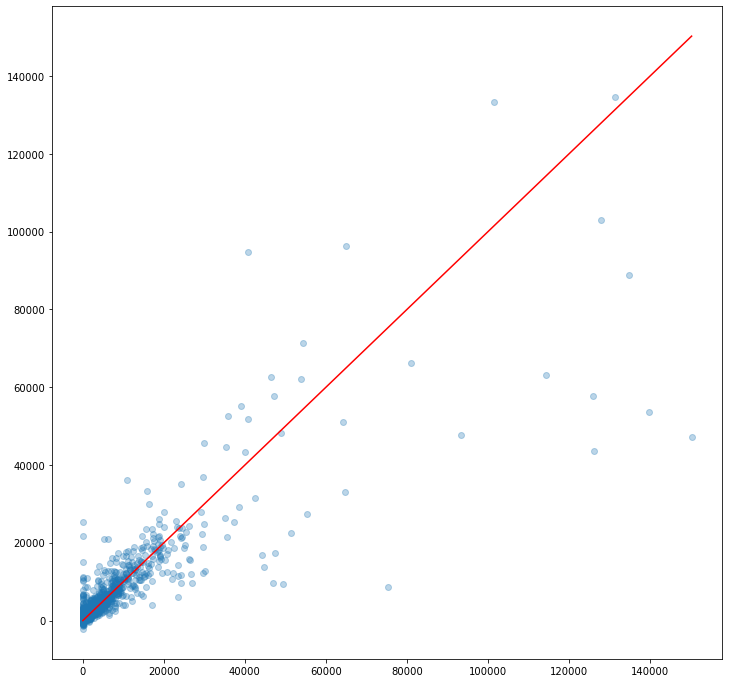

In [28]:
fig, ax = graph_true_vs_predict(y_val, y_val_pred)

The RMSE is slightly better than the base-level model, but the base-level model already performed quite well.

### Regression with SVM

I don't see much point using an out-of-the-box SVM (as I don't know the proper kernel to use) so I will immediately try to determine the best kernel through a grid search. Because this dataset is so large and the time complexity of SVM is pretty high, I will use the SGDRegressor from scikit-learn to optimize the same loss function with a bit more flexibility and less computation.

Since linear SVMs use the epsilon-insensitive loss function (MSE that turns into absolute error after a certain distance), I will use the same loss function with my SGDRegressor. I am also applying an approximated kernel transformer using Nystroem, trying different kernels using a grid search.

In [263]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import Nystroem
from sklearn.model_selection import GridSearchCV

#### Initializing the SVM Pipeline

As mentioned before, I'll start by applying an approximated kernel using Nystroem, followed by standard scaling and then SGDRegressor using the epsilon-insensitive loss function (the same one used on SVM).

In [264]:
nys = Nystroem(random_state=42)
scaler = StandardScaler()
sgd = SGDRegressor(loss = 'epsilon_insensitive', random_state=42, early_stopping=True,
                   n_iter_no_change=10, validation_fraction=0.2)

In [266]:
pipe = Pipeline(steps=[('nys', nys), ('sgd', sgd)])

#### SVM Hyperparameter tuning

This is going to be a long and painful tuning process. Let's start by figuring out the best kernel -- we will assume that the best kernel will be the best, regardless of the settings on the linear stochastic gradient descent. Apparently, we cannot use the 'chi2' or 'additive_chi2' kernel because these can't take negative values as X inputs, so I am not including these in the hyperparameter search.

In [267]:
gamma_range = np.logspace(-9, 3, 13)
alpha = np.logspace(-5, -1, 5)

In [283]:
param_grid = [
    {'nys__kernel': ['rbf', 'laplacian', 'sigmoid'],
     'nys__gamma': gamma_range},
    
    {'nys__kernel': ['linear']},
    
    {'nys__kernel': ['poly'],
     'nys__gamma': gamma_range,
     'nys__degree': [0.5, 2, 3]}
]

In [269]:
search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('nys', Nystroem(random_state=42)),
                                       ('sgd',
                                        SGDRegressor(early_stopping=True,
                                                     loss='epsilon_insensitive',
                                                     n_iter_no_change=10,
                                                     random_state=42,
                                                     validation_fraction=0.2))]),
             n_jobs=-1,
             param_grid=[{'nys__gamma': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'nys__kernel': ['rbf', 'laplacian', 'sigmoid']},
                         {'nys__kernel': ['linear']},
                         {'nys__degree': [0.5, 2, 3],
                          'nys__gamma': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+

In [270]:
print(f"Best CV Score: {search.best_score_}\n\nBest Params: {search.best_params_}")

Best CV Score: 0.007436825377443124

Best Params: {'nys__degree': 0.5, 'nys__gamma': 0.01, 'nys__kernel': 'poly'}


Our CV score is barely positive, which means it is performing just as well as the constant model. Yikes! For learning's sake, let's finish the tuning process.

In [271]:
nys_params = search.best_params_
nys_params

{'nys__degree': 0.5, 'nys__gamma': 0.01, 'nys__kernel': 'poly'}

Next, to tune the SGDRegressor parameters...

In [272]:
param_grid = [
    {'nys__kernel': [nys_params['nys__kernel']],
     'nys__gamma': [nys_params['nys__gamma']],
     'nys__degree': [nys_params['nys__degree']],
     'sgd__alpha': alpha,
     'sgd__epsilon': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]}
]
param_grid

[{'nys__kernel': ['poly'],
  'nys__gamma': [0.01],
  'nys__degree': [0.5],
  'sgd__alpha': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01]),
  'sgd__epsilon': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]}]

In [273]:
search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('nys', Nystroem(random_state=42)),
                                       ('sgd',
                                        SGDRegressor(early_stopping=True,
                                                     loss='epsilon_insensitive',
                                                     n_iter_no_change=10,
                                                     random_state=42,
                                                     validation_fraction=0.2))]),
             n_jobs=-1,
             param_grid=[{'nys__degree': [0.5], 'nys__gamma': [0.01],
                          'nys__kernel': ['poly'],
                          'sgd__alpha': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01]),
                          'sgd__epsilon': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]}])

In [274]:
print(f"Best CV Score: {search.best_score_}\n\nBest Params: {search.best_params_}")

Best CV Score: 0.04576364785092317

Best Params: {'nys__degree': 0.5, 'nys__gamma': 0.01, 'nys__kernel': 'poly', 'sgd__alpha': 0.01, 'sgd__epsilon': 0.5}


Better, but not by much.

In [275]:
best_params = search.best_params_
best_params

{'nys__degree': 0.5,
 'nys__gamma': 0.01,
 'nys__kernel': 'poly',
 'sgd__alpha': 0.01,
 'sgd__epsilon': 0.5}

#### Fitting the Tuned Model

Now that we have the most optimal hyperparameters, let's fit the model to our training set.

In [276]:
nys = Nystroem(random_state=42, kernel = 'poly', degree = best_params['nys__degree'],
               gamma=best_params['nys__gamma'])
sgd = SGDRegressor(loss = 'epsilon_insensitive', alpha = best_params['sgd__alpha'],
                   epsilon = best_params['sgd__epsilon'], random_state=42, early_stopping=True,
                   n_iter_no_change=10, validation_fraction=0.2)

pipe = Pipeline(steps=[('nys', nys), ('scaler', scaler), ('sgd', sgd)])

In [277]:
pipe.fit(X_train, y_train)
y_val_pred = pipe.predict(X_val)

In [281]:
RMSE = RMSE_val(y_val, y_val_pred)
R2 = R2_val(y_val, y_val_pred)
print(f"RMSE: {RMSE}\nR2 = {R2}")

RMSE: 10998.168026220166
R2 = -0.13672773738948685


So the model clearly didn't work, but let's plot the values anyway.

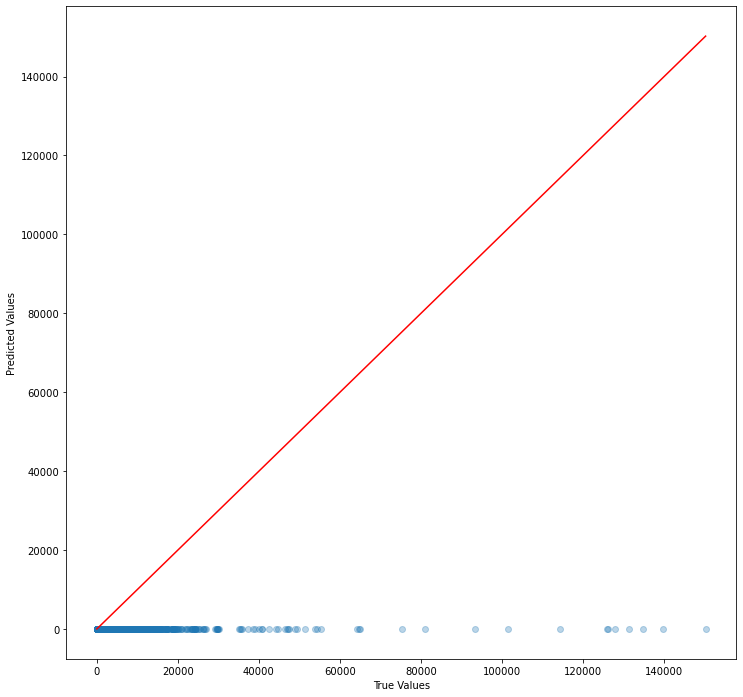

In [282]:
fig, ax = graph_true_vs_predict(y_val, y_val_pred)

#### Trying SVM without a kernel (identity kernel)
The model is predicting values that are simply on the wrong order of magnitude. I am curious whether this is an issue with my kernel. Let's try SGD without it.

In [292]:
pipe = Pipeline(steps=[('scaler', scaler), ('sgd', sgd)])

In [293]:
param_grid = [{
     'sgd__alpha': alpha,
     'sgd__epsilon': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]}
]
param_grid

[{'sgd__alpha': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01]),
  'sgd__epsilon': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]}]

In [294]:
search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('sgd',
                                        SGDRegressor(alpha=1e-05,
                                                     early_stopping=True,
                                                     epsilon=0.2,
                                                     loss='epsilon_insensitive',
                                                     n_iter_no_change=10,
                                                     random_state=42,
                                                     validation_fraction=0.2))]),
             n_jobs=-1,
             param_grid=[{'sgd__alpha': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01]),
                          'sgd__epsilon': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]}])

In [295]:
best_params = search.best_params_

In [296]:
sgd = SGDRegressor(loss = 'epsilon_insensitive', alpha = best_params['sgd__alpha'],
                   epsilon = best_params['sgd__epsilon'], random_state=42, early_stopping=True,
                   n_iter_no_change=10, validation_fraction=0.2)

pipe = Pipeline(steps=[('scaler', scaler), ('sgd', sgd)])

In [297]:
pipe.fit(X_train, y_train)
y_val_pred = pipe.predict(X_val)

In [298]:
RMSE = RMSE_val(y_val, y_val_pred)
R2 = R2_val(y_val, y_val_pred)
print(f"RMSE: {RMSE}\nR2 = {R2}")

RMSE: 10984.22732741668
R2 = -0.13384785126675358


Perhaps SVM Regression doesn't work with this data after all.

### Summary

Since SVM completely failed at beating a constant predictor, I will continue with XGBoost's regressor. As this is my first time using SVM for regression, I will have to look up later whether there is anything crucial I was missing in this implementation.

## Increasing Complexity: Can we use our data to predict case values in advance?

Previously, I have shown that case rates of any given day can be regressed out from google search trends of that day. What's more important, however, is whether these trends can predict case rates *for future days*. I will start again with a base model (this time, XGBRegressor with the features I have been using previously), then engineer a few more features to see if they can improve the model.

#### Making New Outcome Columns: 1-day, 3-day, and 5-day Case Values

First, I need to create the new features to predict. I will make three more outcomes: cases after 1 day, cases after 3 days, and cases after 5 days.

In [8]:
df_ohe = pd.read_csv("COVID19_cases_searches_dayOfWeek.csv", sep=',', parse_dates=['date'])
df_ohe.head()

,state,date,cases,symptom:Stroke,symptom:Eye strain,symptom:Indigestion,symptom:Tenderness,symptom:Angioedema,symptom:Pleurisy,symptom:Middle back pain,...,symptom:Fever,symptom:Low-grade fever,yesterday_val,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,Alabama,2021-01-12,3848,2.60,0.29,1.52,0.11,0.18,0.20,0.38,...,3.88,0.28,3848,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Alabama,2021-01-13,3147,2.71,0.26,1.57,0.15,0.18,0.25,0.37,...,3.92,0.27,3848,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,Alabama,2021-01-14,3588,2.64,0.31,1.66,0.15,0.18,0.21,0.41,...,4.06,0.28,3147,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,Alabama,2021-01-15,2945,2.52,0.27,1.55,0.16,0.15,0.19,0.36,...,3.81,0.27,3588,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Alabama,2021-01-16,3153,2.30,0.27,1.67,0.14,0.24,0.20,0.38,...,3.78,0.26,2945,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [9]:
from datetime import timedelta

In [10]:
df_ohe_predict = df_ohe.copy()

In [11]:
df_ohe_predict['day1'] = df_ohe_predict['date'] + timedelta(days=1)
df_ohe_predict['day3'] = df_ohe_predict['date'] + timedelta(days=3)
df_ohe_predict['day5'] = df_ohe_predict['date'] + timedelta(days=5)

In [12]:
df_ohe_predict.head()

,state,date,cases,symptom:Stroke,symptom:Eye strain,symptom:Indigestion,symptom:Tenderness,symptom:Angioedema,symptom:Pleurisy,symptom:Middle back pain,...,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,day1,day3,day5
0,Alabama,2021-01-12,3848,2.60,0.29,1.52,0.11,0.18,0.20,0.38,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2021-01-13,2021-01-15,2021-01-17
1,Alabama,2021-01-13,3147,2.71,0.26,1.57,0.15,0.18,0.25,0.37,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2021-01-14,2021-01-16,2021-01-18
2,Alabama,2021-01-14,3588,2.64,0.31,1.66,0.15,0.18,0.21,0.41,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2021-01-15,2021-01-17,2021-01-19
3,Alabama,2021-01-15,2945,2.52,0.27,1.55,0.16,0.15,0.19,0.36,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-01-16,2021-01-18,2021-01-20
4,Alabama,2021-01-16,3153,2.30,0.27,1.67,0.14,0.24,0.20,0.38,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2021-01-17,2021-01-19,2021-01-21


In [14]:
df_ohe_predict['day1_cases'] = -9999
df_ohe_predict['day3_cases'] = -9999
df_ohe_predict['day5_cases'] = -9999

In [15]:
for i in range(0, df_ohe.shape[0]):
    state = df_ohe.state[i]
    day1 = str(df_ohe_predict.loc[i,'day1'].date())
    day3 = str(df_ohe_predict.loc[i, 'day3'].date())
    day5 = str(df_ohe_predict.loc[i, 'day5'].date())
    
    try:
        day1_cases = df_ohe_predict[(df_ohe_predict['date'] == day1)
                            & (df_ohe_predict['state'] == state)]['cases'].values[0]
        df_ohe_predict['day1_cases'][i] = day1_cases
    except:
        df_ohe_predict['day1_cases'][i] = -9999
        
    try:
        day3_cases = df_ohe_predict[(df_ohe_predict['date'] == day3)
                            & (df_ohe_predict['state'] == state)]['cases'].values[0]
        df_ohe_predict['day3_cases'][i] = day3_cases
    except:
        df_ohe_predict['day3_cases'][i] = -9999
        
    try:
        day5_cases = df_ohe_predict[(df_ohe_predict['date'] == day5)
                            & (df_ohe_predict['state'] == state)]['cases'].values[0]
        df_ohe_predict['day5_cases'][i] = day5_cases
    except:
        df_ohe_predict['day5_cases'][i] = -9999
        

df_ohe_predict.head()

/var/folders/nn/04fg5y513pdg807378fs9m7cpm0jsw/T/ipykernel_78060/560378350.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ohe_predict['day1_cases'][i] = day1_cases
/var/folders/nn/04fg5y513pdg807378fs9m7cpm0jsw/T/ipykernel_78060/560378350.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ohe_predict['day3_cases'][i] = day3_cases
/var/folders/nn/04fg5y513pdg807378fs9m7cpm0jsw/T/ipykernel_78060/560378350.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

,state,date,cases,symptom:Stroke,symptom:Eye strain,symptom:Indigestion,symptom:Tenderness,symptom:Angioedema,symptom:Pleurisy,symptom:Middle back pain,...,Sunday,Thursday,Tuesday,Wednesday,day1,day3,day5,day1_cases,day3_cases,day5_cases
0,Alabama,2021-01-12,3848,2.60,0.29,1.52,0.11,0.18,0.20,0.38,...,0.0,0.0,1.0,0.0,2021-01-13,2021-01-15,2021-01-17,3147,2945,1917
1,Alabama,2021-01-13,3147,2.71,0.26,1.57,0.15,0.18,0.25,0.37,...,0.0,0.0,0.0,1.0,2021-01-14,2021-01-16,2021-01-18,3588,3153,1430
2,Alabama,2021-01-14,3588,2.64,0.31,1.66,0.15,0.18,0.21,0.41,...,0.0,1.0,0.0,0.0,2021-01-15,2021-01-17,2021-01-19,2945,1917,2515
3,Alabama,2021-01-15,2945,2.52,0.27,1.55,0.16,0.15,0.19,0.36,...,0.0,0.0,0.0,0.0,2021-01-16,2021-01-18,2021-01-20,3153,1430,3112
4,Alabama,2021-01-16,3153,2.30,0.27,1.67,0.14,0.24,0.20,0.38,...,0.0,0.0,0.0,0.0,2021-01-17,2021-01-19,2021-01-21,1917,2515,2881


In [326]:
df_ohe_predict.head(10)

,state,date,cases,symptom:Stroke,symptom:Eye strain,symptom:Indigestion,symptom:Tenderness,symptom:Angioedema,symptom:Pleurisy,symptom:Middle back pain,...,Sunday,Thursday,Tuesday,Wednesday,day1,day3,day5,day1_cases,day3_cases,day5_cases
0,Alabama,2021-01-12,3848,2.60,0.29,1.52,0.11,0.18,0.20,0.38,...,0.0,0.0,1.0,0.0,2021-01-13,2021-01-15,2021-01-17,3147,2945,1917
1,Alabama,2021-01-13,3147,2.71,0.26,1.57,0.15,0.18,0.25,0.37,...,0.0,0.0,0.0,1.0,2021-01-14,2021-01-16,2021-01-18,3588,3153,1430
2,Alabama,2021-01-14,3588,2.64,0.31,1.66,0.15,0.18,0.21,0.41,...,0.0,1.0,0.0,0.0,2021-01-15,2021-01-17,2021-01-19,2945,1917,2515
3,Alabama,2021-01-15,2945,2.52,0.27,1.55,0.16,0.15,0.19,0.36,...,0.0,0.0,0.0,0.0,2021-01-16,2021-01-18,2021-01-20,3153,1430,3112
4,Alabama,2021-01-16,3153,2.30,0.27,1.67,0.14,0.24,0.20,0.38,...,0.0,0.0,0.0,0.0,2021-01-17,2021-01-19,2021-01-21,1917,2515,2881
5,Alabama,2021-01-17,1917,2.20,0.29,1.75,0.21,0.16,0.20,0.38,...,1.0,0.0,0.0,0.0,2021-01-18,2021-01-20,2021-01-22,1430,3112,3551
6,Alabama,2021-01-18,1430,2.75,0.28,1.64,0.18,0.20,0.20,0.41,...,0.0,0.0,0.0,0.0,2021-01-19,2021-01-21,2021-01-23,2515,2881,3355
7,Alabama,2021-01-19,2515,2.75,0.30,1.70,0.19,0.16,0.19,0.36,...,0.0,0.0,1.0,0.0,2021-01-20,2021-01-22,2021-01-24,3112,3551,1728
8,Alabama,2021-01-20,3112,2.76,0.23,1.56,0.12,0.16,0.23,0.36,...,0.0,0.0,0.0,1.0,2021-01-21,2021-01-23,2021-01-25,2881,3355,1839
9,Alabama,2021-01-21,2881,2.82,0.32,1.67,0.14,0.17,0.28,0.43,...,0.0,1.0,0.0,0.0,2021-01-22,2021-01-24,2021-01-26,3551,1728,2900


In [16]:
df_ohe_predict = df_ohe_predict.drop(['yesterday_val', 'day1', 'day3', 'day5'], axis=1).set_index(['state','date','cases','day1_cases','day3_cases','day5_cases']).reset_index()
df_ohe_predict.head()

,state,date,cases,day1_cases,day3_cases,day5_cases,symptom:Stroke,symptom:Eye strain,symptom:Indigestion,symptom:Tenderness,...,total_distributed,symptom:Fever,symptom:Low-grade fever,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,Alabama,2021-01-12,3848,3147,2945,1917,2.60,0.29,1.52,0.11,...,377025.0,3.88,0.28,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Alabama,2021-01-13,3147,3588,3153,1430,2.71,0.26,1.57,0.15,...,378975.0,3.92,0.27,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,Alabama,2021-01-14,3588,2945,1917,2515,2.64,0.31,1.66,0.15,...,435350.0,4.06,0.28,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,Alabama,2021-01-15,2945,3153,1430,3112,2.52,0.27,1.55,0.16,...,444650.0,3.81,0.27,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Alabama,2021-01-16,3153,1917,2515,2881,2.30,0.27,1.67,0.14,...,444650.0,3.78,0.26,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [17]:
df_ohe_predict.to_csv("COVID19_cases_searches_futurePredict.csv", index=False)

In [18]:
df = pd.read_csv("COVID19_cases_searches_futurePredict.csv", parse_dates=['date'])
df.head()

,state,date,cases,day1_cases,day3_cases,day5_cases,symptom:Stroke,symptom:Eye strain,symptom:Indigestion,symptom:Tenderness,...,total_distributed,symptom:Fever,symptom:Low-grade fever,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,Alabama,2021-01-12,3848,3147,2945,1917,2.60,0.29,1.52,0.11,...,377025.0,3.88,0.28,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Alabama,2021-01-13,3147,3588,3153,1430,2.71,0.26,1.57,0.15,...,378975.0,3.92,0.27,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,Alabama,2021-01-14,3588,2945,1917,2515,2.64,0.31,1.66,0.15,...,435350.0,4.06,0.28,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,Alabama,2021-01-15,2945,3153,1430,3112,2.52,0.27,1.55,0.16,...,444650.0,3.81,0.27,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Alabama,2021-01-16,3153,1917,2515,2881,2.30,0.27,1.67,0.14,...,444650.0,3.78,0.26,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [19]:
df_d1 = df.drop(['day3_cases', 'day5_cases'], axis=1)
df_d3 = df.drop(['day1_cases', 'day5_cases'], axis=1)
df_d5 = df.drop(['day1_cases', 'day3_cases'], axis=1)

In [20]:
df_d1 = df_d1[df_d1['day1_cases'] != -9999]
df_d3 = df_d3[df_d3['day3_cases'] != -9999]
df_d5 = df_d5[df_d5['day5_cases'] != -9999]
df_d1.shape

(12151, 86)

In [21]:
df_d1.to_csv("COVID19_cases_searches_day1_pred.csv", index=False)
df_d3.to_csv("COVID19_cases_searches_day3_pred.csv", index=False)
df_d5.to_csv("COVID19_cases_searches_day5_pred.csv", index=False)

### The Base Model: XGBoost with the Given Features

We will load in the dataframes with the values to predict, then we will generate train and test sets for each of them.

In [37]:
df_d1 = pd.read_csv("COVID19_cases_searches_day1_pred.csv").drop(['state','date'],axis=1)
df_d3 = pd.read_csv("COVID19_cases_searches_day3_pred.csv").drop(['state','date'],axis=1)
df_d5 = pd.read_csv("COVID19_cases_searches_day5_pred.csv").drop(['state','date'],axis=1)

In [ ]:
params1 = {'max_depth': 6,
           'min_child_weight': 1,
           'eta': 0.3,
           'subsample': 1,
           'colsample_bytree': 1,
           'objective': 'reg:squarederror',
           'eval_metric': 'rmse',
           'early_stopping_rounds':10,
           'random_state': 42,
           'n_estimators' = 999}

params3 = params1.copy()
params5 = params1.copy()

num_boost_round = 999

In [39]:
X_train_d1, X_test_d1, y_train_d1, y_test_d1 = train_test_split(df_d1.drop("day1_cases", axis=1),
                                                  df_d1["day1_cases"],
                                                  test_size=0.2,
                                                  random_state=42)

X_train_d3, X_test_d3, y_train_d3, y_test_d3 = train_test_split(df_d3.drop("day3_cases", axis=1),
                                                  df_d3["day3_cases"],
                                                  test_size=0.2,
                                                  random_state=42)

X_train_d5, X_test_d5, y_train_d5, y_test_d5 = train_test_split(df_d5.drop("day5_cases", axis=1),
                                                  df_d5["day5_cases"],
                                                  test_size=0.2,
                                                  random_state=42)

X_train_d5.shape, X_test_d5.shape, y_train_d5.shape, y_test_d5.shape


((9628, 83), (2407, 83), (9628,), (2407,))

In [43]:
dtrain1 = xgb.DMatrix(data=X_train_d1, label=y_train_d1)

res1 = xgb.cv(params1, dtrain1, num_boost_round=num_boost_round, nfold=5,
             metrics={'rmse'}, seed=42,
             early_stopping_rounds=10,
             callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)])

dtrain3 = xgb.DMatrix(data=X_train_d3, label=y_train_d3)

res3 = xgb.cv(params3, dtrain3, num_boost_round=num_boost_round, nfold=5,
             metrics={'rmse'}, seed=42,
             early_stopping_rounds=10,
             callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)])

dtrain5 = xgb.DMatrix(data=X_train_d5, label=y_train_d5)

res5 = xgb.cv(params5, dtrain5, num_boost_round=num_boost_round, nfold=5,
             metrics={'rmse'}, seed=42,
             early_stopping_rounds=10,
             callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)])

[0]	train-rmse:7862.25850+83.14209	test-rmse:8393.75127+517.32046
[1]	train-rmse:6416.65478+63.42494	test-rmse:7601.85459+496.77355
[2]	train-rmse:5401.74404+40.96131	test-rmse:6999.41543+347.27399
[3]	train-rmse:4635.14746+55.81831	test-rmse:6592.32920+358.17916
[4]	train-rmse:4120.24819+57.47767	test-rmse:6422.16602+315.69063
[5]	train-rmse:3717.31548+85.02253	test-rmse:6288.31611+333.98000
[6]	train-rmse:3409.17646+102.46980	test-rmse:6153.65576+300.82133
[7]	train-rmse:3186.77012+112.64423	test-rmse:6135.81475+295.64408
[8]	train-rmse:3009.46894+121.50967	test-rmse:6037.57119+236.83522
[9]	train-rmse:2860.02959+86.56745	test-rmse:5990.18652+223.26837
[10]	train-rmse:2712.88599+46.71704	test-rmse:5959.90811+239.72096
[11]	train-rmse:2608.39321+46.76585	test-rmse:5942.67012+232.93414
[12]	train-rmse:2519.83179+58.01612	test-rmse:5914.85186+224.80693
[13]	train-rmse:2431.88105+63.30275	test-rmse:5901.12031+231.72459
[14]	train-rmse:2329.63198+50.27539	test-rmse:5895.37881+236.14781
[1

In [46]:
min_rmse1 = res1['test-rmse-mean'].min()
min_rmse3 = res3['test-rmse-mean'].min()
min_rmse5 = res5['test-rmse-mean'].min()

In [54]:
min_rmse1, min_rmse3, min_rmse5

(5771.5511718, 6037.7894534, 6283.1888674)

#### Helper Function for Hyperparameter Tuning

In [86]:
def hyperparameter_tuning_xgb(data, params, grid, param_names):
    
    ## generate baseline RMSE
    baseline_res = xgb.cv(params, data, num_boost_round=num_boost_round, nfold=5,
                         metrics={'rmse'}, seed=42,
                         early_stopping_rounds=10)
    min_rmse = baseline_res['test-rmse-mean'].min()
    
    ## begin hyperparameter fitting
    
    keep_param = None
    for entry in grid:
        
        if not isinstance(entry, list):
            entry = [entry]
        
        for i in range(0, len(entry)):
            name = param_names[i]
            print(str(param_names[i]) + ": " + str(entry[i]))
            params[name] = entry[i]
            
        
        res = xgb.cv(params, data, num_boost_round = num_boost_round,
                     seed = 42, nfold = 5, metrics = {'rmse'},
                     early_stopping_rounds = 10)

        rmse = res['test-rmse-mean'].min()
        print("Res = " + str(rmse))
        std = res[res['test-rmse-mean'] == rmse]['test-rmse-std'].values[0]
        print('StDev = ' + str(std))
    
        # checks if rmse is less than previous best:
        if rmse <= min_rmse:
            min_rmse = res['test-rmse-mean'].min()
            keep_param = entry
        
        print('')
    
    for i in range(0, len(param_names)):
        params[param_names[i]] = keep_param[i]
    
    return params
    
    

#### Hyperparameter Tuning
Let's perform hyperparameter tuning to find 3 sets of parameters to match our three different prediction outcomes.

In [93]:
param_grid1 = [[max_depth, min_child_weight] for max_depth in range(6,12) for min_child_weight in range(1,8)]

In [94]:
param_grid1

[[6, 1],
 [6, 2],
 [6, 3],
 [6, 4],
 [6, 5],
 [6, 6],
 [6, 7],
 [7, 1],
 [7, 2],
 [7, 3],
 [7, 4],
 [7, 5],
 [7, 6],
 [7, 7],
 [8, 1],
 [8, 2],
 [8, 3],
 [8, 4],
 [8, 5],
 [8, 6],
 [8, 7],
 [9, 1],
 [9, 2],
 [9, 3],
 [9, 4],
 [9, 5],
 [9, 6],
 [9, 7],
 [10, 1],
 [10, 2],
 [10, 3],
 [10, 4],
 [10, 5],
 [10, 6],
 [10, 7],
 [11, 1],
 [11, 2],
 [11, 3],
 [11, 4],
 [11, 5],
 [11, 6],
 [11, 7]]

In [80]:
params1 = hyperparameter_tuning_xgb(dtrain1, params1, param_grid1, ['max_depth', 'min_child_weight'])
params1

KeyboardInterrupt: 

In [95]:
param_grid2 = [[subsample, colsample_bytree]
               for subsample in np.linspace(0.5,1,6)
               for colsample_bytree in np.linspace(0.5,1,6)]

In [81]:
params1 = hyperparameter_tuning_xgb(dtrain1, params1, param_grid2, ['subsample', 'colsample_bytree'])
params1

subsample: 0.5
colsample_bytree: 0.5
Res = 6174.4454102
StDev = 392.28534363846575

subsample: 0.5
colsample_bytree: 0.6
Res = 6389.6982422
StDev = 410.06398367414744

subsample: 0.5
colsample_bytree: 0.7
Res = 6404.4546874
StDev = 332.4159416284216

subsample: 0.5
colsample_bytree: 0.8
Res = 6339.825195200001
StDev = 430.6697353669224

subsample: 0.5
colsample_bytree: 0.9
Res = 6287.132324200001
StDev = 502.5097641356031

subsample: 0.5
colsample_bytree: 1.0
Res = 6192.637109400001
StDev = 686.4602981894886

subsample: 0.6
colsample_bytree: 0.5
Res = 6081.0740233999995
StDev = 580.175042452497

subsample: 0.6
colsample_bytree: 0.6
Res = 6120.7359376
StDev = 616.0007060936543

subsample: 0.6
colsample_bytree: 0.7
Res = 5908.4620118
StDev = 631.5779063062276

subsample: 0.6
colsample_bytree: 0.8
Res = 5912.3721678
StDev = 417.1061407016397

subsample: 0.6
colsample_bytree: 0.9
Res = 6066.4998048
StDev = 393.6904322330358

subsample: 0.6
colsample_bytree: 1.0
Res = 6277.4364258000005
StD

{'max_depth': 6,
 'min_child_weight': 2,
 'eta': 0.3,
 'subsample': 0.8,
 'colsample_bytree': 0.5,
 'objective': 'reg:squarederror',
 'eval_metric': 'rmse'}

In [84]:
eta_grid = [0.5, 0.3, 0.2, 0.1, 0.05, 0.01, 0.001]

In [88]:
params1 = hyperparameter_tuning_xgb(dtrain1, params1, eta_grid, ['eta'])
params1

eta: 0.5
Res = 6204.4886716
StDev = 129.76846789429732

eta: 0.3
Res = 5659.119629
StDev = 336.70599379454177

eta: 0.2
Res = 5632.384961000001
StDev = 394.0309260179151

eta: 0.1
Res = 5525.2288086
StDev = 364.4783117367039

eta: 0.05
Res = 5447.5596682000005
StDev = 357.4280606944322

eta: 0.01
Res = 5470.300390599999
StDev = 367.8611001901162

eta: 0.001
Res = 6932.8820312
StDev = 487.87961588886645



{'max_depth': 6,
 'min_child_weight': 2,
 'eta': 0.05,
 'subsample': 0.8,
 'colsample_bytree': 0.5,
 'objective': 'reg:squarederror',
 'eval_metric': 'rmse'}

In [98]:
params1_final = params1.copy()
params1_final

{'max_depth': 6,
 'min_child_weight': 2,
 'eta': 0.05,
 'subsample': 0.8,
 'colsample_bytree': 0.5,
 'objective': 'reg:squarederror',
 'eval_metric': 'rmse'}

Next, trying to find optimal parameters for predicting cases 3 days after observation...

In [82]:
params3 = hyperparameter_tuning_xgb(dtrain3, params3, param_grid1, ['max_depth', 'min_child_weight'])
params3

max_depth: 6
min_child_weight: 1
Res = 6037.7894534
StDev = 620.9284304668591

max_depth: 6
min_child_weight: 2
Res = 6015.3085937999995
StDev = 574.1670062668037

max_depth: 6
min_child_weight: 3
Res = 6081.533789200001
StDev = 553.0450519369087

max_depth: 6
min_child_weight: 4
Res = 6018.4026367999995
StDev = 465.62215173297136

max_depth: 6
min_child_weight: 5
Res = 6157.4732422
StDev = 535.1109608984752

max_depth: 6
min_child_weight: 6
Res = 6082.115625
StDev = 567.499214599133

max_depth: 6
min_child_weight: 7
Res = 6072.221582
StDev = 507.9500835063201

max_depth: 7
min_child_weight: 1
Res = 6132.313183599999
StDev = 576.8209543605576

max_depth: 7
min_child_weight: 2
Res = 6058.670215
StDev = 633.5020012520682

max_depth: 7
min_child_weight: 3
Res = 6097.4452148
StDev = 494.37279227717124

max_depth: 7
min_child_weight: 4
Res = 6031.1680664000005
StDev = 533.3926754775367

max_depth: 7
min_child_weight: 5
Res = 6015.3301758
StDev = 474.6518332301395

max_depth: 7
min_child_wei

{'max_depth': 8,
 'min_child_weight': 7,
 'eta': 0.3,
 'subsample': 1,
 'colsample_bytree': 1,
 'objective': 'reg:squarederror',
 'eval_metric': 'rmse'}

In [83]:
params3 =  hyperparameter_tuning_xgb(dtrain3, params3, param_grid2, ['subsample', 'colsample_bytree'])
params3

subsample: 0.5
colsample_bytree: 0.5
Res = 6393.5173826
StDev = 506.3944037937792

subsample: 0.5
colsample_bytree: 0.6
Res = 6334.925097599999
StDev = 370.0653917529923

subsample: 0.5
colsample_bytree: 0.7
Res = 6375.4042968
StDev = 624.899976702985

subsample: 0.5
colsample_bytree: 0.8
Res = 6245.978320200001
StDev = 541.2106963338915

subsample: 0.5
colsample_bytree: 0.9
Res = 6177.8910156
StDev = 482.7115015416936

subsample: 0.5
colsample_bytree: 1.0
Res = 6363.923339800001
StDev = 574.2503854416769

subsample: 0.6
colsample_bytree: 0.5
Res = 6103.7294922
StDev = 498.56237243164577

subsample: 0.6
colsample_bytree: 0.6
Res = 6312.3947264
StDev = 581.3597201572207

subsample: 0.6
colsample_bytree: 0.7
Res = 6337.484961
StDev = 585.3631568419155

subsample: 0.6
colsample_bytree: 0.8
Res = 6235.2536132
StDev = 522.7900718519667

subsample: 0.6
colsample_bytree: 0.9
Res = 6296.4969726
StDev = 545.0815178731631

subsample: 0.6
colsample_bytree: 1.0
Res = 6193.1849608
StDev = 659.28054

{'max_depth': 8,
 'min_child_weight': 7,
 'eta': 0.3,
 'subsample': 1.0,
 'colsample_bytree': 0.7,
 'objective': 'reg:squarederror',
 'eval_metric': 'rmse'}

In [87]:
params3 = hyperparameter_tuning_xgb(dtrain3, params3, eta_grid, ['eta'])
params3 

eta: 0.5
Res = 6291.7267575999995
StDev = 661.1557219914147

eta: 0.3
Res = 5922.5978514
StDev = 551.529772517313

eta: 0.2
Res = 5890.549023199999
StDev = 637.3832735712969

eta: 0.1
Res = 5825.250488199999
StDev = 676.3202401116412

eta: 0.05
Res = 5830.452246
StDev = 679.6378765286659

eta: 0.01
Res = 5825.3078126
StDev = 657.0448787255615

eta: 0.001
Res = 6791.237988399999
StDev = 727.7483390696125



{'max_depth': 8,
 'min_child_weight': 7,
 'eta': 0.1,
 'subsample': 1.0,
 'colsample_bytree': 0.7,
 'objective': 'reg:squarederror',
 'eval_metric': 'rmse'}

In [99]:
params3_final = params3.copy()

In [105]:
params5

{'max_depth': 6,
 'min_child_weight': 1,
 'eta': 0.01,
 'subsample': 1.0,
 'colsample_bytree': 1.0,
 'objective': 'reg:squarederror',
 'eval_metric': 'rmse'}

In [106]:
params5 = hyperparameter_tuning_xgb(dtrain5, params5, param_grid1, ['max_depth', 'min_child_weight'])
params5 = hyperparameter_tuning_xgb(dtrain5, params5, param_grid2, ['subsample', 'colsample_bytree'])
params5 = hyperparameter_tuning_xgb(dtrain5, params5, eta_grid, ['eta'])
params5

max_depth: 6
min_child_weight: 1


KeyboardInterrupt: 

In [ ]:
params5_final = params5.copy()

#### Final Tuned Models

Now that we have more optimized hyperparameters, we can create new models to fit.

In [ ]:
xgb_tuned = xgb.XGBRegressor(params5_final, n_estimators = 999,
                             early_stopping_rounds=10, random_state=42)

xgb_tuned.fit(X_train_d5, y_train_d5)

In [ ]:
xgb_tuned = xgb.XGBRegressor(n_estimators = 999, max_depth=params['max_depth'],
                             min_child_weight=params['min_child_weight'],
                             eta = params['eta'],
                             subsample = params['subsample'],
                             colsample_bytree = params['colsample_bytree'],
                             objective = params['objective'],
                             eval_metric = params['eval_metric'],
                             early_stopping_rounds=10, random_state=42)

xgb_tuned.fit(X_train, y_train)

## Longitudinal Model

Finally, let's reformat the dataframe into one that can be easily put into the model.

In [13]:
wide_df = longitudinal_cleaned.pivot(index='date', columns=['state', 'county'])
wide_df = wide_df.reorder_levels(["state", "county", None], axis=1)
wide_df.shape

(430, 608)

Written in this way, it's clear that our variable-to-observation ratio is way too high for model prediction. For now, I will focus on Howard County (maryland), with its surrounding counties (Carroll, baltimore, montgomery, anne arundel, and prince george's).

In [14]:
wide_df_subset = wide_df['Maryland'][['Howard', 'Carroll', 'Baltimore', 'Montgomery', 'Anne Arundel', "Prince George's"]]
wide_df_subset

county     Howard                                              Carroll         \
            cases deaths dose1_pop_pct series_complete_pop_pct   cases deaths   
date                                                                            
2021-01-02    123      0           0.0                     0.0      64      0   
2021-01-03     78      0           0.0                     0.0      41      3   
2021-01-04     93      0           0.0                     0.0      38      1   
2021-01-05     87      1           0.0                     0.0      68      3   
2021-01-06    141      0           0.0                     0.0      78      1   
...           ...    ...           ...                     ...     ...    ...   
2022-03-03     25      0          94.5                    84.9      20      0   
2022-03-04     19      0          94.5                    84.9      20      1   
2022-03-05     13      0          94.5                    85.0      18      0   
2022-03-06     14      0          94.6                    85.0       4      0   
2022-03-07     10      0          94.6                    85.0      15      0   

county                                           Baltimore         ...  \
           dose1_pop_pct series_complete_pop_pct     cases deaths  ...   
date                                                               ...   
2021-01-02           0.0                     0.0       350      4  ...   
2021-01-03           0.0                     0.0       257      5  ...   
2021-01-04           0.0                     0.0       243      3  ...   
2021-01-05           0.0                     0.0       175      8  ...   
2021-01-06           0.0                     0.0       402      9  ...   
...                  ...                     ...       ...    ...  ...   
2022-03-03          80.4                    73.3        50      3  ...   
2022-03-04          80.4                    73.3        36      2  ...   
2022-03-05          80.4                    73.3        37      2  ...   
2022-03-06          80.4                    73.3        26      0  ...   
2022-03-07          80.5                    73.3        23      1  ...   

county        Montgomery                         Anne Arundel         \
           dose1_pop_pct series_complete_pop_pct        cases deaths   
date                                                                   
2021-01-02           1.3                     0.0          328      2   
2021-01-03           1.4                     0.0          222      0   
2021-01-04           1.4                     0.0          264      1   
2021-01-05           1.7                     0.0          152      5   
2021-01-06           1.8                     0.0          349      3   
...                  ...                     ...          ...    ...   
2022-03-03          95.0                    85.6           69      3   
2022-03-04          95.0                    85.7           43      1   
2022-03-05          95.0                    85.7           31      0   
2022-03-06          95.0                    85.7           23      0   
2022-03-07          95.0                    85.7           22      0   

county                                           Prince George's         \
           dose1_pop_pct series_complete_pop_pct           cases deaths   
date                                                                      
2021-01-02           0.0                     0.0             555      7   
2021-01-03           0.0                     0.0             334      1   
2021-01-04           0.0                     0.0             363      3   
2021-01-05           0.0                     0.0             422      1   
2021-01-06           0.0                     0.0             473     10   
...                  ...                     ...             ...    ...   
2022-03-03          85.8                    76.1              21      4   
2022-03-04          85.8                    76.2              39     

## Model Building

For now, I would like to start with a 'naive' model -- one that doesn't contain any non-longitudinal census metadata. After previously visualizing the case rates in various Maryland counties (see last notebook), I am inclined to start with a LSTM recurrent neural network in order to better model interactions between the features we are interested in, particularly how cases in one location may influence cases in another. My creation of the LSTM recurrent neural network is largely based off of Hvass Lab's tutorial on using a RNN for weather data. It can be found here: https://github.com/Hvass-Labs/TensorFlow-Tutorials as tutorial 23. After looking through many other tutorials, I believe that this tutorial has data which most closely matches up with the format of my own data, so it will be helpful for me as I use my first neural network model of time series.

I will later do an ARIMA (and potentially a simple GLM) in order to have a more simple model + get more interpretability out of the data.

Again, I aim to predict the cases and deaths in Howard County.

In [15]:
county = "Howard"
vb_to_predict = ['cases', 'deaths']

Let's try to predict the case and death rate 1 week from the given date. We will make a data frame with the "real" values -- these are the values that we want the model to predict, given the input.

In [16]:
shift = 7 # for seven days

shift_vals = wide_df_subset[county][vb_to_predict].shift(-shift)
shift_vals.tail(10) ### I want to make sure that I shifted in the correct direction. It appears to be correct, as the last seven days have null values.

,cases,deaths
date,,
2022-02-26,13.0,0.0
2022-02-27,14.0,0.0
2022-02-28,10.0,0.0
2022-03-01,NaN,NaN
2022-03-02,NaN,NaN
2022-03-03,NaN,NaN
2022-03-04,NaN,NaN
2022-03-05,NaN,NaN
2022-03-06,NaN,NaN


Next, let's make our X and y arrays.

In [17]:
X = wide_df_subset.values[:-shift]
y = shift_vals.values[:-shift]
X.shape, y.shape

((423, 24), (423, 2))

Test-train splitting, and normalizing all values to [0, 1] for the neural network to handle.

In [18]:
train_split = int(0.8 * len(X))
test_split = len(X)-train_split

X_train = X[:train_split]
X_test = X[train_split:]
y_train = y[:train_split]
y_test = y[train_split:]

scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(X_train)
x_test_s = scaler.transform(X_test) 

y_scaler = MinMaxScaler()
y_train_s = y_scaler.fit_transform(y_train)
y_test_s = y_scaler.transform(y_test)

In [19]:
num_x_signals = X.shape[1] # number of inputs per time point
num_y_signals = y.shape[1] # number of outputs per time point

Hvass Labs uses a batch generator function (seen below) to generate batches for training the RNN. Since we only have 400-so observations, I don't believe I will need this, but I will use it anyway because 430 observations may be at the limit of my GPU's memory capacity.

In their case, they have a dataset with over 300k observations. Therefore, if they use a sequence length of 1344, they can still expect that most of their batches will not overlap over the training data. This is not a luxury that I will likely have.

In [20]:
batch_size = 128
sequence_length = 64 # about 2 months

In [21]:
### Taken straight from Hvass Labs' tutorial. In this case, sequence length is the number of consecutive observations that you will want from a batch.

def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(train_split - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_s[idx:idx+sequence_length]
            y_batch[i] = y_train_s[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

They initialize the batch generator and use it as so:

In [22]:
generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)
x_batch, y_batch = next(generator)

While we're training on small batches of 32 days, we will do our validation runs on the entire test dataset for hyperparameter tuning. In order to let us feed this entire dataset in, we will have to expand the dimension by 1 to fit the "None" dimension that TensorFlow's API always likes as a wildcard dimension.

In [23]:
validation_data = (np.expand_dims(x_test_s, axis=0), np.expand_dims(y_test_s, axis=0))

## Building the Model with TensorFlow

I was originally going to build this with TensorFlow's functional API (in order to load in the other metadata that's not longitudinal), but I've had a lot of trouble trying to figure out how the longitudinal data will mesh with the non-longitudinal data. For this reason I decided to create my midterm without the other metadata for now, since I can use the (much easier) sequential API. I hope to figure out how to work with the dataframes on the functional API by the final project deadline.

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean
from tensorflow.keras.layers import Input, GRU, Dense, Embedding

Any RNN will be of the form: Input > Recurrent Units > Dense. Let's initialize it as such. Frankly, I am not sure how many neurons we will need per recurrent layer, so I will set it for now to 128. Hvass used 512 for an input layer of (None, 20,) so it is probably too small, but I can change this later during hyperparameter optimization.

In [25]:
model=Sequential()
model.add(GRU(units=128, return_sequences=True,
              input_shape=(None, num_x_signals,)))
model.add(Dense(num_y_signals, activation='sigmoid')) # I am using sigmoid because I was told to! I am not what alternatives exist for an RNN.

2022-04-04 22:52:33.037621: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-04 22:52:33.100282: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-04 22:52:33.100569: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-04 22:52:33.101487: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

As with most regression models, we'll use root mean squared error (RMSE) as our loss function. Hvass Labs' tutorial suggests that we don't want the model to "train" on the earliest time steps, as loss value can fluctuate wildly. They give a "warmup" period where the loss function isn't used.

In [26]:
warmup = 10 # Here I am really understanding the problem of "only" having 430 time points.

### again, adapted from Hvass Labs' tutorial. Essentially, this function slices the predicted and true y values to only calculate the RMSE
### with the period after the warmup steps.
def loss_function(y_true, y_pred): 
    y_true_slice = y_true[:, warmup:, :]
    y_pred_slice = y_pred[:, warmup:, :]
    
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

Finally to compile our model.

In [27]:
optimizer = RMSprop(learning_rate=0.001) # This LR is a bit high but we have a function to reduce LR upon plateau...

In [28]:
model.compile(loss=loss_function, optimizer=optimizer)

This TensorFlow tutorial now introduces me to TensorBoard, which is a auto-controller that can make changes to the model between epochs. This is very cool -- previously I would run epoch by epoch to manually control these things, but this provides a convenient alternative. I read through the documentation and am still not completely understanding how it works though, so this code to help monitor and change the model learning process is heavily adapted again from this Hvass Labs tutorial.

In [29]:
path_checkpoint = 'checkpoint.keras'
### this writes checkpoints
callback_checkpoint = ModelCheckpoint(filepath = path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)
### this allows for early stopping if the validation loss continues decreasing upon further training.
callback_early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1) # consider increasing the patience slightly.
### This writes the log during training.
callback_tensorboard = TensorBoard(log_dir = './tensorboard_logs/',
                                   histogram_freq=0,
                                   write_graph=False)
### Finally, this reduces the learning rate upon plateau.
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=0.0001,
                                       patience=0, # consider changing this to 1
                                       verbose=1)

callbacks = [callback_early_stopping, callback_checkpoint, callback_tensorboard, callback_reduce_lr]

Finally, to train the model.

In [30]:
model.fit(x=generator,
          epochs=100,
          steps_per_epoch=100,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/100


2022-04-04 22:52:37.656258: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8301
2022-04-04 22:52:37.837714: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


 96/100 [===========================>..] - ETA: 0s - loss: 0.0107
Epoch 1: val_loss improved from inf to 0.66048, saving model to checkpoint.keras
100/100 [==============================] - 4s 12ms/step - loss: 0.0105 - val_loss: 0.6605 - lr: 0.0010
Epoch 2/100
 95/100 [===========================>..] - ETA: 0s - loss: 0.0055
Epoch 2: val_loss improved from 0.66048 to 0.62805, saving model to checkpoint.keras
100/100 [==============================] - 1s 8ms/step - loss: 0.0055 - val_loss: 0.6280 - lr: 0.0010
Epoch 3/100
 93/100 [==========================>...] - ETA: 0s - loss: 0.0047
Epoch 3: val_loss did not improve from 0.62805

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 1s 8ms/step - loss: 0.0047 - val_loss: 0.6518 - lr: 0.0010
Epoch 4/100
 95/100 [===========================>..] - ETA: 0s - loss: 0.0044
Epoch 4: val_loss did not improve from 0.62805

Epoch 4: ReduceLROnPlateau reducing learning rate to 0

Well, we can see here that the validation loss didn't really decrease at all, suggesting that the model isn't learning anything from the epochs. Also, the stopping at epoch 7 (patience=5) suggests that really only 1 epoch actually "helped" in the learning process. It's possible that this is because the batch size + sample size basically tiles over the entire validation set (which is composed of the entire X_train and y_train).

Next, let's load the best model (which was saved as epoch 2 in the checkpoint).

In [29]:
model.load_weights(path_checkpoint)

In [30]:
result = model.evaluate(x=np.expand_dims(x_test_s, axis=0),
                        y=np.expand_dims(y_test_s, axis=0))

1/1 [==============================] - 0s 13ms/step - loss: 0.6576


Finally, another function heavily influenced by a similar function by Hvass Labs to visualize this data. Essentially, this pulls out a slice of the training dataset of a given length and with a given start index, then plots the real values vs. the predicted values.

In [31]:
def plot_comparison(start, length=100):
    # We just need the end index for slicing the dataframes
    end = start + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    
    
    X = x_train_s[start:end]
    y_true = y_train[start:end]
    
    # We will prepare this "slice" to load into our model for prediction.
    X = np.expand_dims(X, axis=0)

    # This will give us the predicted values from the model.
    y_pred = model.predict(X)
    
    # We have to invert the output (which was in sigmoid)
    # back to the original scale.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # We will make a separate graph for each variable to predict.
    for outcome in range(len(vb_to_predict)):
        
        # Here's the prediction with only the two columns that we are interested in.
        outcome_pred = y_pred_rescaled[:, outcome]
        
        # We will also pull these columns out of Y-true.
        outcome_true = y_true[:, outcome]


        plt.figure(figsize=(15,5))

        plt.plot(outcome_true, label='true')
        plt.plot(outcome_pred, label='pred')
        
        # Plot labels etc.
        plt.ylabel(vb_to_predict[outcome])
        plt.legend()
        plt.show()

In [32]:
### essentially the same thing, but for plotting the test set.
def plot_comparison_test(start, length=100):

    end = start + length
    

    X = x_test_s[start:end]
    y_true = y_test[start:end]
    
    # We will prepare this "slice" to load into our model for prediction.
    X = np.expand_dims(X, axis=0)

    # This will give us the predicted values from the model.
    y_pred = model.predict(X)
    
    # We have to invert the output (which was in sigmoid)
    # back to the original scale.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # We will make a separate graph for each variable to predict.
    for outcome in range(len(vb_to_predict)):
        
        # Here's the prediction with only the two columns that we are interested in.
        outcome_pred = y_pred_rescaled[:, outcome]
        
        # We will also pull these columns out of Y-true.
        outcome_true = y_true[:, outcome]


        plt.figure(figsize=(15,5))

        plt.plot(outcome_true, label='true')
        plt.plot(outcome_pred, label='pred')
        
        # Plot labels etc.
        plt.ylabel(vb_to_predict[outcome])
        plt.legend()
        plt.show()

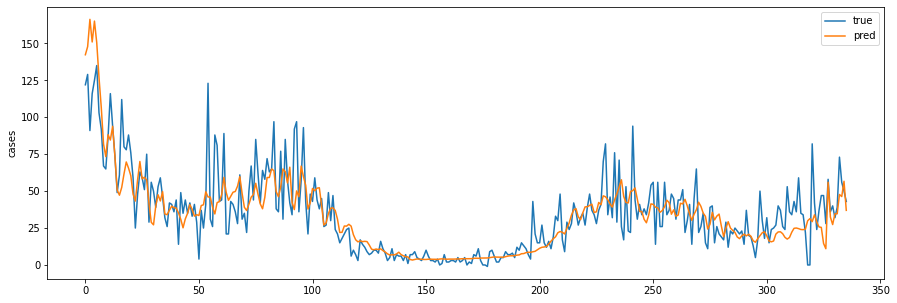

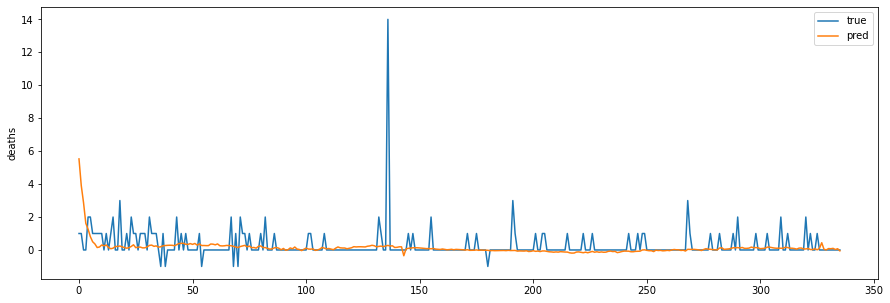

In [33]:
plot_comparison(start=2, length=400)

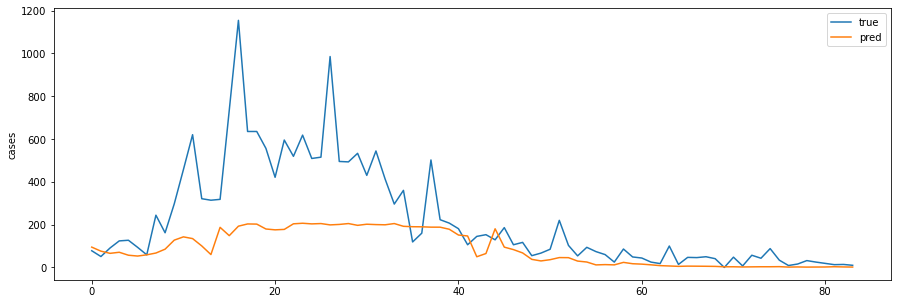

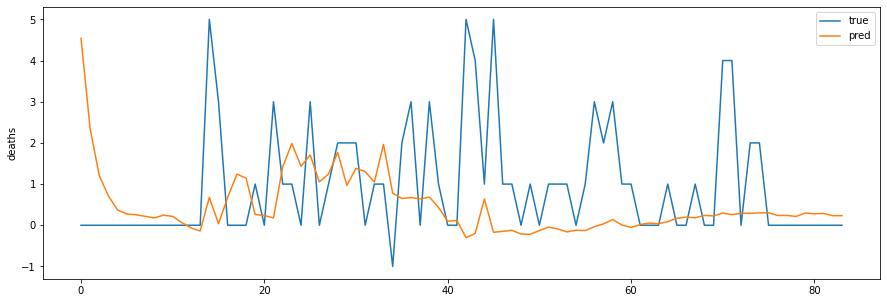

In [34]:
### now to plot the test data:
plot_comparison_test(start=1, length=84)

This is what I was afraid of. While the model is able to fit decently well to case levels on the training set, it is unable to predict the cases in the test set. I am not terribly surprised by this because I am skeptical that the last 3 months of my data (during Omicron) are at all representative of of the data from the previous year. It seems like many hidden variables changed during that time which weren't reflected in the features that I provided to the model.

## Next Steps

It seems clear to me that there are other hidden variables at play that may better predict the movement of COVID cases over time. I suspect that at least some of these hidden variables include demographic/other metadata information that I will load into my model later. However, this initial modelling has suggested that I need more longitudinal data to better forecast COVID Cases. Here are some ideas of my next plans:
1. Drop "deaths" from the dataframe, and focus on simply predicting cases
2. Find other COVID-adjacent, longitudinal data per county. These may include: hospitalizations per county, number of Google searches about COVID per county, etc.
3. Load other metadata into the model
4. Go for more simpler models (i.e. AR time series like ARIMA) to see whether they are competitive against this poor RNN model.
5. Compare my metadata against others provided by the COVID-19 ForecastHub (https://covid19forecasthub.org/reports/single_page.html) in order to see what data sources they use for their ensemble predictions.

## Citations

Hvass Laboratory's tutorial on Recurrent Neural Networks on TensorFlow: https://github.com/Hvass-Labs/TensorFlow-Tutorials

McDonald, Daniel et al., 2021 (https://www.pnas.org/doi/10.1073/pnas.2111453118)

Barcellos, Demian et al., 2021 (https://www.nature.com/articles/s41598-021-04029-6#change-history)

COVID-19 ForecastHub (https://covid19forecasthub.org/reports/single_page.html)
